In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from math import log2

import torchvision.transforms as T
import torchvision.datasets as datasets
from torch.utils.data import DataLoader

from tqdm import tqdm
import matplotlib.pyplot as plt

from torchsummary import summary

In [ ]:
BATCH_SIZE = 1
CHANNEL_IMG = 3             # RGB
LEARNING_RATE = 2e-3
IMAGE_SIZE = 1024
Z_DIM = 256
W_DIM = Z_DIM
IN_CHANNEL = 256
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
# DEVICE = 'cpu'
DATASET_PATH = "celeba_hq/train"

EPOCHES_PER_BLOCK = [1]*9 # [10]*9

In [ ]:
factors = [1,1,1,1,1/2,1/4,1/8,1/16,1/32]

In [ ]:
class Conv2d(nn.Module):
    def __init__(self, in_channel, out_channel, kernel=3, stride=1, padding=1, gain=2):
        super().__init__()
        self.conv = nn.Conv2d(in_channel, out_channel, kernel, stride, padding)
        self.scale_factor = (gain/(in_channel* kernel**2))**0.5 # That He initlisation thing

        # bias will not be scaled
        self.bias = self.conv.bias
        self.conv.bias = None

        # implement He init - for equalised learning rate
        nn.init.normal_(self.conv.weight)
        nn.init.zeros_(self.bias)

    def forward(self, x):
        return self.conv(x * self.scale_factor) + self.bias.view(1, self.bias.shape[0], 1, 1)


In [ ]:
# Taken from : https://github.com/kukosmos/adain-pytorch-2019/blob/master/utils.py

class AdaIN(nn.Module):
    def __init__(self):
        super().__init__()

    def calc_mean_std(feat, eps=1e-8):  # Original was 1e-5
        size = feat.size()
        N, C = size[:2]

        feat_mean = feat.view(N, C, -1).mean(dim=2).view(N, C, 1, 1)

        feat_var = feat.view(N, C, -1).var(dim=2) + eps
        feat_std = feat_var.sqrt().view(N, C, 1, 1)

        return feat_mean, feat_std

    def forward(self, content_feat, style_feat_a, style_feat_b):
        size = content_feat.size()

        # style_mean, style_std = AdaIN.calc_mean_std(style_feat)
        content_mean, content_std = AdaIN.calc_mean_std(content_feat)

        normalized_feat = (content_feat - content_mean.expand(size)) / content_std.expand(size)

        normalized_feat = normalized_feat * style_feat_a + style_feat_b
        # print(normalized_feat)
        return normalized_feat

In [ ]:
class A_Block(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer = nn.Linear(W_DIM, 2)

    def forward(self, x):
        x = self.layer(x)
        x = F.leaky_relu(x, 0.2)
        return x

In [ ]:
class B_block(nn.Module):
    def __init__(self, channel):
        super().__init__()

        self.factor = torch.randn(BATCH_SIZE, channel, 1, 1)
        nn.init.normal_(self.factor)
        self.factor.requires_grad = True

    def forward(self, x):
        return self.factor * x

In [ ]:
class Z_to_W_MLP(nn.Module):
    def __init__(self, layers=8):
        super().__init__()

        self.mlp_layers = nn.ModuleList()
        self.mlp_layers.append(nn.Linear(Z_DIM, W_DIM))
        for i in range(layers-1):
            self.mlp_layers.append(nn.Linear(W_DIM, W_DIM))
        self.leaky = nn.LeakyReLU(0.2)

    def forward(self, x):
        for layer in self.mlp_layers:
            x = layer(x)
            x = self.leaky(x)
        return x

In [ ]:
class Blocks(nn.Module):
    def __init__(self, in_channel, out_channel):
        super().__init__()
        self.conv1 = Conv2d(in_channel, out_channel)
        self.a1 = A_Block()
        self.b1 = B_block(out_channel)
        self.conv2 = Conv2d(out_channel, out_channel)
        self.a2 = A_Block()
        self.b2 = B_block(out_channel)
        self.leaky = nn.LeakyReLU(0.2)
        self.adain = AdaIN()

    def forward(self, prev, w):
        prev = self.leaky( self.conv1(prev) )
        prev += self.b1(torch.randn_like(prev))
        a = self.a1(w)[0]
        sigma, bias = a[0], a[1]
        prev = self.adain(prev, sigma, bias)


        prev = self.leaky( self.conv2(prev) )
        prev += self.b2(torch.randn_like(prev))
        a = self.a2(w)[0]
        sigma, bias = a[0], a[1]
        prev = self.adain(prev, sigma, bias)
        return prev

In [ ]:
class Init_Block(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv2 = Conv2d(IN_CHANNEL, IN_CHANNEL)
        self.a1 = A_Block()
        self.b1 = B_block(IN_CHANNEL)
        self.a2 = A_Block()
        self.b2 = B_block(IN_CHANNEL)
        self.leaky = nn.LeakyReLU(0.2)
        self.adain = AdaIN()

    def forward(self, w):
        prev = torch.ones(BATCH_SIZE, IN_CHANNEL, 4, 4)

        prev += self.b1(torch.randn_like(prev))
        a = self.a1(w)[0]
        sigma, bias = a[0], a[1]
        prev = self.adain(prev, sigma, bias)

        prev = self.leaky( self.conv2(prev) )
        prev += self.b2(torch.randn_like(prev))
        a = self.a2(w)[0]
        sigma, bias = a[0], a[1]
        prev = self.adain(prev, sigma, bias)
        return prev

In [ ]:
class Generator(nn.Module):
    def __init__(self): # , in_channel=512, img_channel=3):
        super().__init__()
        self.initialBlock = Init_Block()
        self.initial_toRGB = Conv2d(IN_CHANNEL, CHANNEL_IMG, kernel=1, stride=1, padding=0)

        self.pro_blocks, self.to_rgbRGB_layers = nn.ModuleList(), nn.ModuleList( [self.initial_toRGB] )

        for i in range(len(factors) - 1):
            conv_in_channel = int(IN_CHANNEL * factors[i])
            conv_out_channel = int(IN_CHANNEL * factors[i+1])

            self.pro_blocks.append(Blocks(conv_in_channel, conv_out_channel))
            self.to_rgbRGB_layers.append(Conv2d(conv_out_channel, CHANNEL_IMG, kernel=1, stride=1, padding=0))

    def fade_in(self, alpha, upscaled, generated):
        return torch.tanh(alpha*generated + (1-alpha)*upscaled)

    def forward(self, w, alpha=0.5, steps=8): # steps=0 -> 4x4 ; steps=1 -> 8x8
        out = self.initialBlock(w)
        if steps == 0:
            return self.initial_toRGB(out)

        for step in range(steps):
            upscaled = F.interpolate(out, scale_factor=2, mode="bilinear")
            out = self.pro_blocks[step](upscaled, w)

        final_upscaled = self.to_rgbRGB_layers[steps-1](upscaled)
        final_out = self.to_rgbRGB_layers[steps](out)

        return self.fade_in(alpha, final_upscaled, final_out)

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.pro_blocks, self.to_RGB_layers = nn.ModuleList(), nn.ModuleList()
        self.leaky = nn.LeakyReLU(0.2)

        for i in range(len(factors) - 1, 0, -1):
            conv_in_channel = int(IN_CHANNEL * factors[i])
            conv_out_channel = int(IN_CHANNEL * factors[i-1])
            # print(conv_in_channel, conv_out_channel)
            self.pro_blocks.append(Blocks(conv_in_channel, conv_out_channel))
            self.to_RGB_layers.append(Conv2d(CHANNEL_IMG, conv_in_channel, kernel=1, stride=1, padding=0))

        self.initial_toRGB = Conv2d(CHANNEL_IMG, IN_CHANNEL, kernel=1, stride=1, padding=0)
        self.to_RGB_layers.append(self.initial_toRGB)
        # self.downsample = nn.AvgPool2d(kernel_size=2, stride=2)
        self.downsample = lambda x : F.interpolate(x, scale_factor=0.5, mode="bilinear")

        self.final_block = nn.Sequential(
            Conv2d(IN_CHANNEL, IN_CHANNEL, kernel=3, stride=1, padding=1), # mini batch std removed
            nn.LeakyReLU(0.2),
            Conv2d(IN_CHANNEL, IN_CHANNEL, kernel=4, padding=0, stride=1),
            nn.LeakyReLU(0.2),
            Conv2d(IN_CHANNEL, 1, kernel=1, padding=0, stride=1)
        )

    def fade_in(self, alpha, downscaled, out):
        return alpha*out + (1-alpha)*downscaled

    # def miniBatch_std(self, x):
    #     batch_stat = torch.std(x, dim=0).mean().repeat(x.shape[0],1,x.shape[2],x.shape[3])
    #     return torch.cat([x, batch_stat], dim=1)

    def forward(self, x, alpha, steps, w):
        curr_step = len(self.pro_blocks) - steps
        out = self.leaky( self.to_RGB_layers[curr_step](x))

        if steps == 0:
            # out = self.miniBatch_std(out)
            return self.final_block(out).view(out.shape[0], -1)

        downscaled = self.leaky( self.to_RGB_layers[curr_step + 1](self.downsample(x)) )
        out = self.downsample(self.pro_blocks[curr_step](out, w))

        for step in range(curr_step+1, len(self.pro_blocks)):
            out = self.pro_blocks[step](out, w)
            out = self.downsample(out)

        # out = self.miniBatch_std(out)
        return self.final_block(out).view(out.shape[0],-1)

In [ ]:
# Z_DIM = 50
# IN_CHANNEL = 256

gen = Generator()
mapper = Z_to_W_MLP()
critic = Discriminator()

for img_size in [4,8,16,32,64,128,256,512,1024]:
    num_steps = int(log2(img_size/4))

    x = torch.randn((BATCH_SIZE,Z_DIM))
    x = mapper(x)
    z = gen(x, 0.5, num_steps)

    assert z.shape == (BATCH_SIZE,3, img_size, img_size)

    out = critic(z, alpha=0.5, steps=num_steps, w=x)
    assert out.shape == (BATCH_SIZE,1)

    print(f"Success! At img size : {img_size}")



Success! At img size : 4
Success! At img size : 8
Success! At img size : 16
Success! At img size : 32
Success! At img size : 64
Success! At img size : 128
Success! At img size : 256
Success! At img size : 512
Success! At img size : 1024


# Train Setup

In [ ]:
! pip install kaggle

! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/

! chmod 600 ~/.kaggle/kaggle.json

! kaggle datasets download -d lamsimon/celebahq

100% 2.55G/2.55G [01:19<00:00, 42.9MB/s]
100% 2.55G/2.55G [01:19<00:00, 34.2MB/s]


In [ ]:
! unzip celebahq.zip

Streaming output truncated to the last 5000 lines.
  inflating: celeba_hq/train/male/140695.jpg  
  inflating: celeba_hq/train/male/140721.jpg  
  inflating: celeba_hq/train/male/140741.jpg  
  inflating: celeba_hq/train/male/140761.jpg  
  inflating: celeba_hq/train/male/140768.jpg  
  inflating: celeba_hq/train/male/140777.jpg  
  inflating: celeba_hq/train/male/140787.jpg  
  inflating: celeba_hq/train/male/140792.jpg  
  inflating: celeba_hq/train/male/140798.jpg  
  inflating: celeba_hq/train/male/140823.jpg  
  inflating: celeba_hq/train/male/140846.jpg  
  inflating: celeba_hq/train/male/140857.jpg  
  inflating: celeba_hq/train/male/140889.jpg  
  inflating: celeba_hq/train/male/140938.jpg  
  inflating: celeba_hq/train/male/140951.jpg  
  inflating: celeba_hq/train/male/140963.jpg  
  inflating: celeba_hq/train/male/140980.jpg  
  inflating: celeba_hq/train/male/141029.jpg  
  inflating: celeba_hq/train/male/141052.jpg  
  inflating: celeba_hq/train/male/141061.jpg  
  inflati

In [ ]:
def get_loader(image_size):
    transform = T.Compose(
        [
            T.Resize((image_size, image_size)),
            T.ToTensor(),
            T.RandomHorizontalFlip(p=0.5),
            T.Normalize(
                [0.5 for _ in range(CHANNEL_IMG)],
                [0.5 for _ in range(CHANNEL_IMG)]
            )
        ]
    )
    dataset = datasets.ImageFolder(root=DATASET_PATH, transform=transform)
    loader = DataLoader(
        dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        drop_last=True
    )
    return loader, dataset

In [ ]:
def train_an_epoch(critic,gen,mapper,loader,opt_gen,opt_critic,opt_mapper,dataset,alpha, step):
    loop = tqdm(loader, leave=True)
    noise_plot = torch.randn((BATCH_SIZE,Z_DIM)).to(DEVICE)
    noise_plot = mapper(noise_plot)
    for batch_idx, (real, _) in enumerate(loop):
        real = real.to(DEVICE)

        # ========================== CRITIC ==============================
        # max (E[critic(real)] - E[critic(fake)])
        # OR
        # min -(E[critic(real)] - E[critic(fake)])

        noise = torch.randn((BATCH_SIZE,Z_DIM)).to(DEVICE)
        noise = mapper(noise)
        fake = gen(noise, alpha, step)
        critic_real = critic(real, alpha, step, w=noise)
        critic_fake = critic(fake.detach(), alpha, step, w=noise) # detached cuz do not train gen -> fake comes out of gen

        loss_critic = (
            -(torch.mean(torch.log(critic_real+1e-8) - torch.log(1-critic_fake+1e-8)))
            # + (0.001 * torch.mean(critic_real ** 2)) # Drift mentioned in paper
            # Gradient Penalty is not implemented
        )
        opt_critic.zero_grad()
        loss_critic.backward()
        opt_critic.step()

        # ============================ GEN ===========================
        fake = gen(noise, alpha, step)
        gen_fake = critic(fake, alpha, step, w=noise)
        loss_gen = -torch.mean(torch.log(gen_fake+1e-8))

        opt_gen.zero_grad()
        opt_mapper.zero_grad()
        loss_gen.backward()
        opt_mapper.step()
        opt_gen.step()

        if batch_idx%50 == 0:

          fake = gen(noise_plot, alpha, step)  # step=0 ; so 1st layer 4x4
          fake = fake.permute(0,2,3,1).cpu().detach().squeeze().numpy()
          print(fake.shape)

          plt.imshow(fake)
          plt.show()

        alpha += BATCH_SIZE/(len(dataset))
        alpha = min(alpha, 1)

    return alpha


Image Size : 4


  0%|          | 0/28000 [00:00<?, ?it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 4, 3)


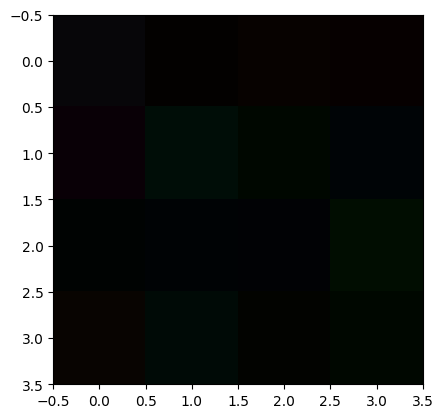

  0%|          | 49/28000 [00:04<34:19, 13.57it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 4, 3)


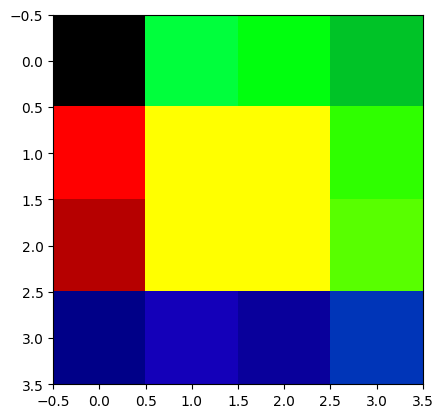

  0%|          | 99/28000 [00:08<32:48, 14.17it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 4, 3)


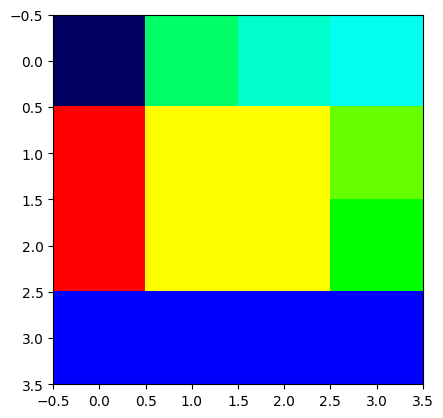

  1%|          | 149/28000 [00:12<32:29, 14.29it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 4, 3)


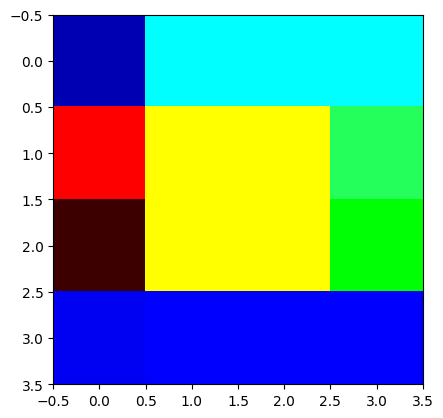

  1%|          | 199/28000 [00:16<38:34, 12.01it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 4, 3)


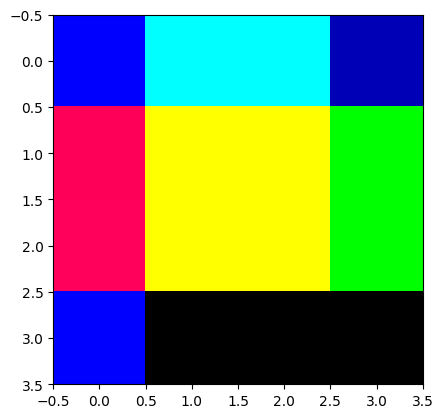

  1%|          | 249/28000 [00:20<32:32, 14.21it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 4, 3)


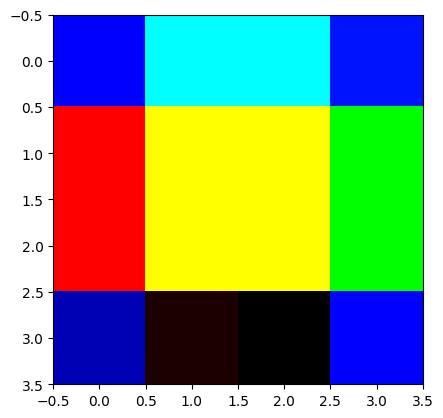

  1%|          | 299/28000 [00:24<32:34, 14.17it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 4, 3)


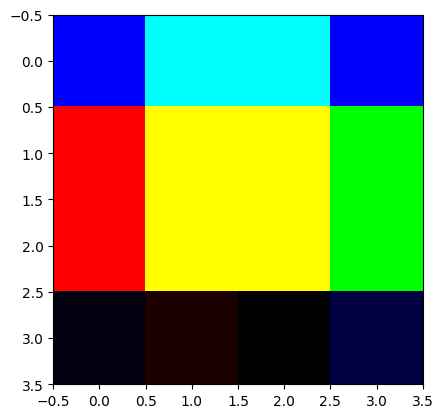

  1%|          | 349/28000 [00:28<45:28, 10.14it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 4, 3)


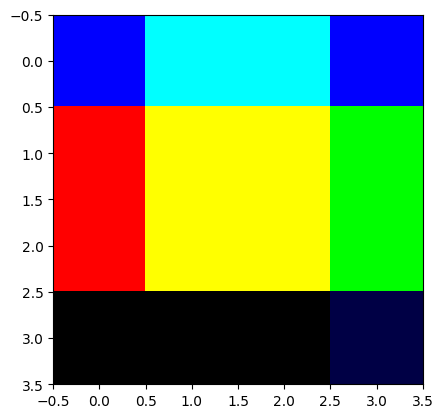

  1%|▏         | 399/28000 [00:32<32:18, 14.24it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 4, 3)


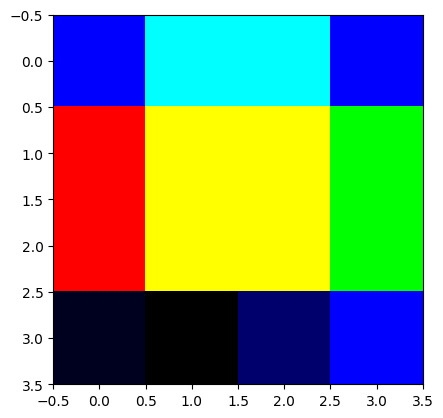

  2%|▏         | 449/28000 [00:36<32:14, 14.25it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 4, 3)


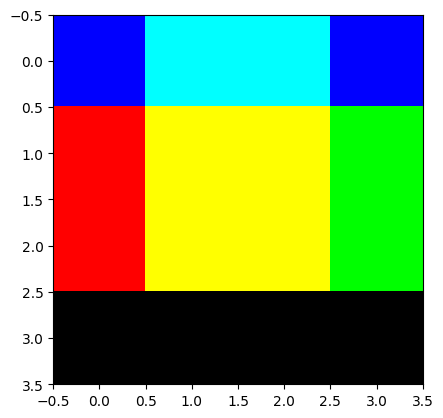

  2%|▏         | 499/28000 [00:40<43:15, 10.60it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 4, 3)


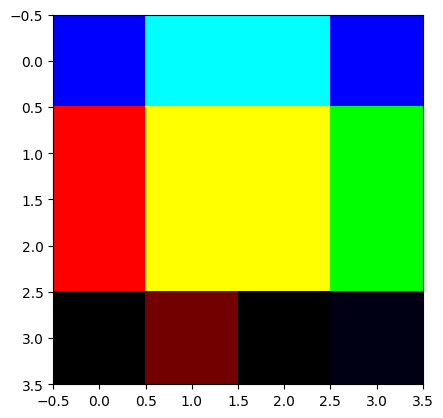

  2%|▏         | 549/28000 [00:44<32:10, 14.22it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 4, 3)


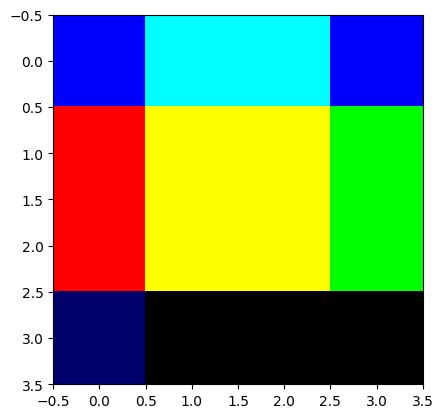

  2%|▏         | 600/28000 [00:48<32:44, 13.95it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 4, 3)


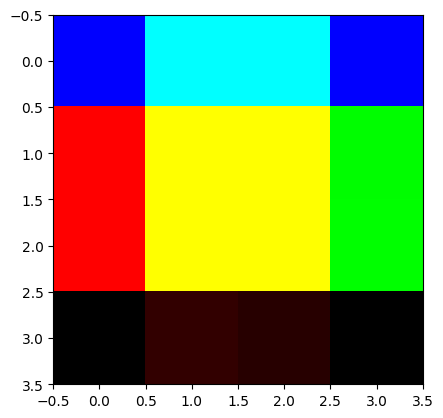

  2%|▏         | 650/28000 [00:53<45:28, 10.02it/s]

(4, 4, 3)


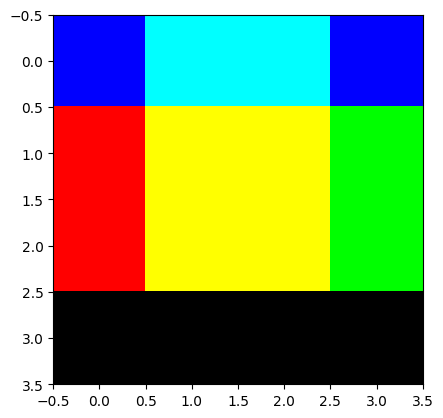

  2%|▏         | 699/28000 [00:57<32:00, 14.22it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 4, 3)


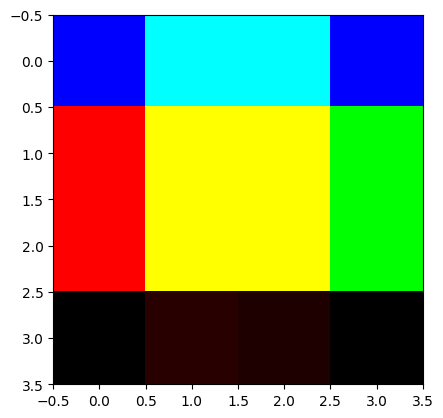

  3%|▎         | 749/28000 [01:01<32:33, 13.95it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 4, 3)


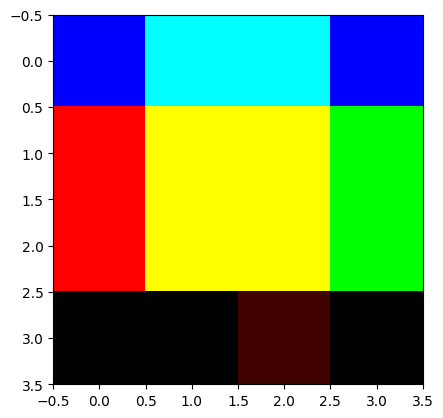

  3%|▎         | 799/28000 [01:05<40:39, 11.15it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 4, 3)


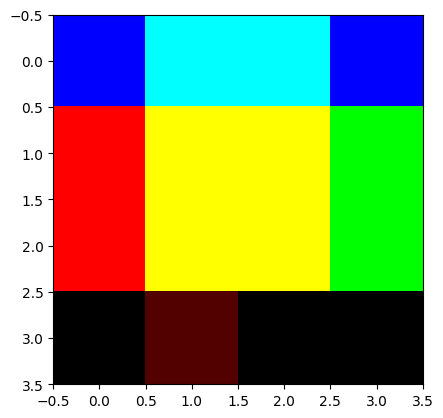

  3%|▎         | 849/28000 [01:10<32:19, 14.00it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 4, 3)


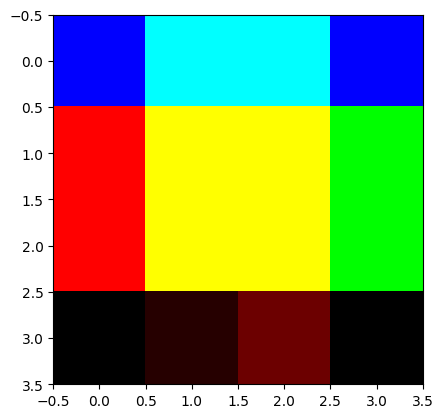

  3%|▎         | 899/28000 [01:13<31:55, 14.15it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 4, 3)


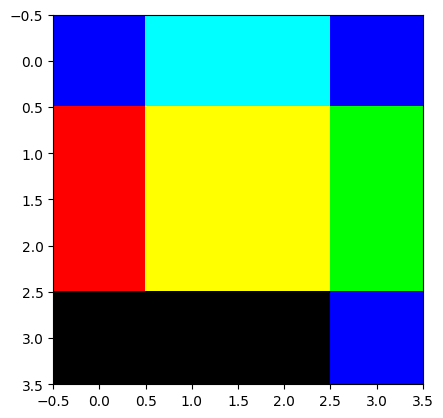

  3%|▎         | 949/28000 [01:17<32:27, 13.89it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 4, 3)


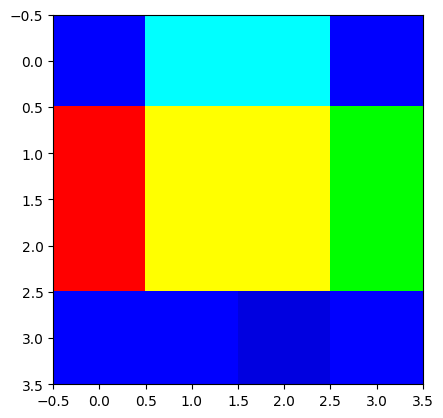

  4%|▎         | 999/28000 [01:22<32:16, 13.94it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 4, 3)


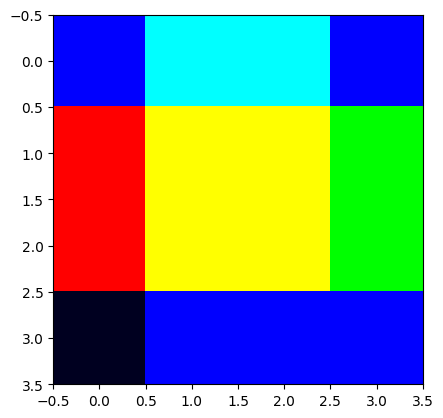

  4%|▎         | 1049/28000 [01:25<32:35, 13.78it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 4, 3)


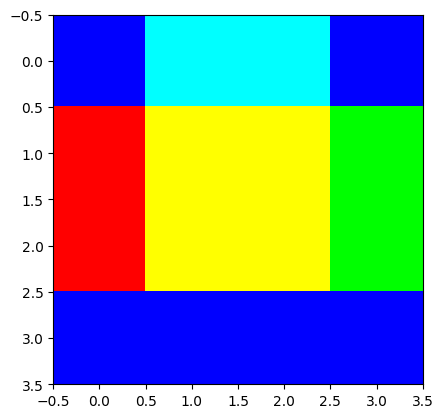

  4%|▍         | 1099/28000 [01:29<31:25, 14.26it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 4, 3)


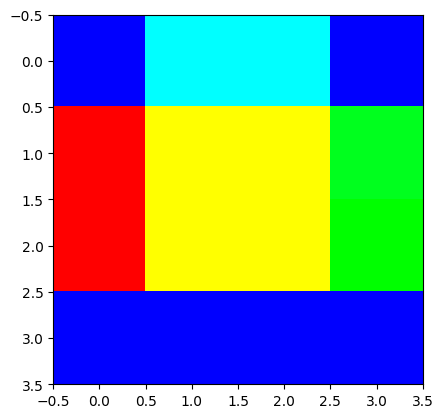

  4%|▍         | 1150/28000 [01:34<32:34, 13.74it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 4, 3)


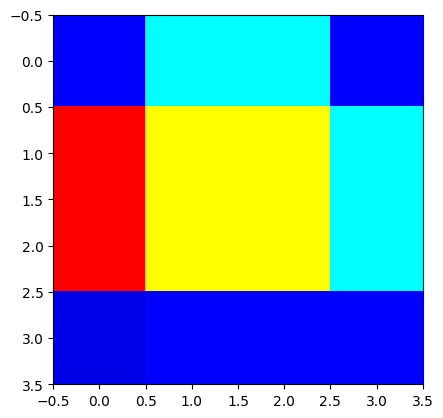

  4%|▍         | 1200/28000 [01:38<33:25, 13.36it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 4, 3)


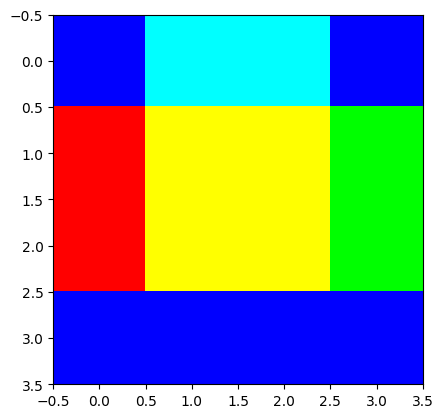

  4%|▍         | 1250/28000 [01:41<31:33, 14.13it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 4, 3)


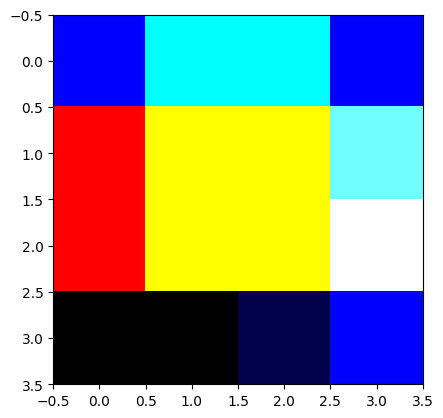

  5%|▍         | 1300/28000 [01:46<37:52, 11.75it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 4, 3)


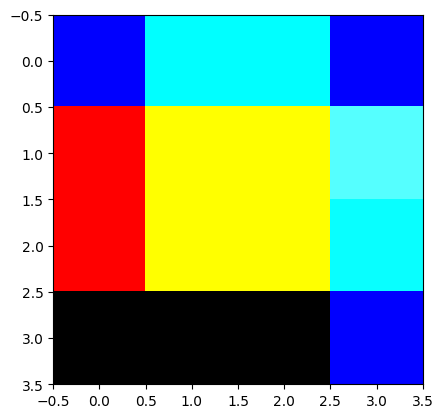

  5%|▍         | 1350/28000 [01:50<31:52, 13.94it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 4, 3)


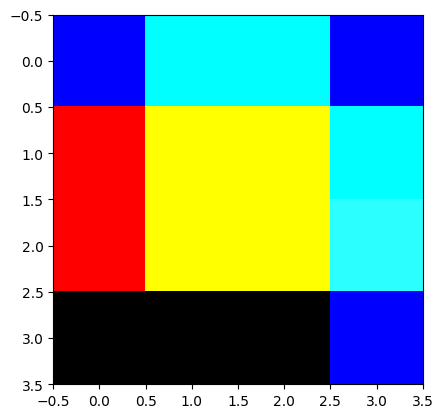

  5%|▌         | 1400/28000 [01:54<31:51, 13.91it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 4, 3)


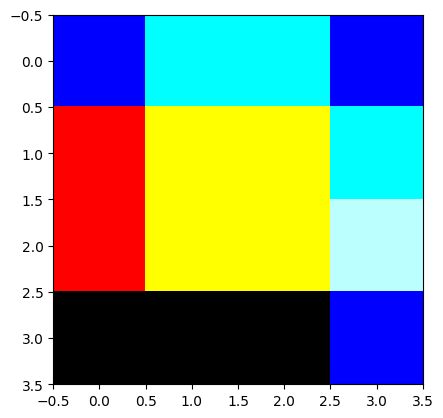

  5%|▌         | 1450/28000 [01:58<42:58, 10.30it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 4, 3)


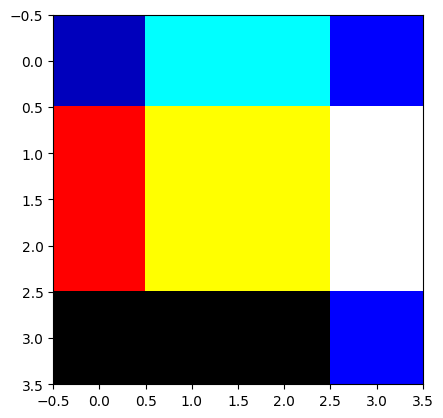

  5%|▌         | 1500/28000 [02:02<31:36, 13.97it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 4, 3)


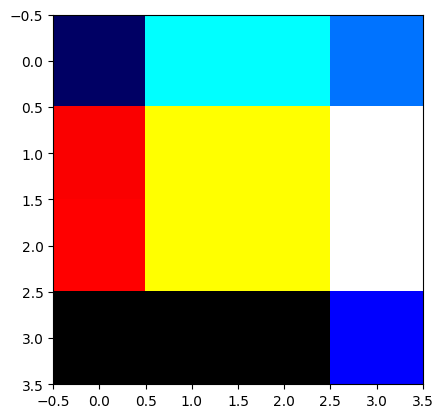

  6%|▌         | 1550/28000 [02:06<31:39, 13.93it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 4, 3)


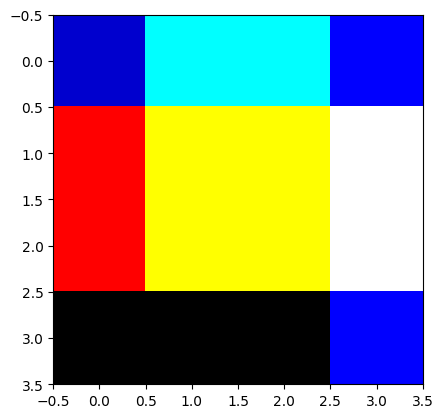

  6%|▌         | 1600/28000 [02:10<42:58, 10.24it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 4, 3)


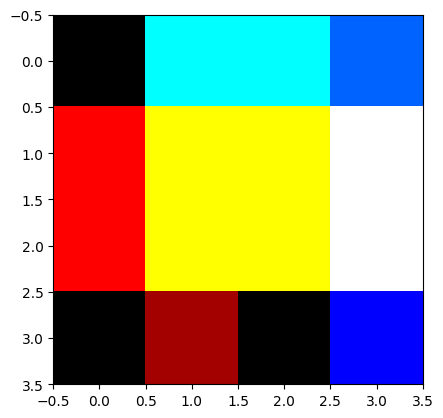

  6%|▌         | 1649/28000 [02:15<32:00, 13.72it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 4, 3)


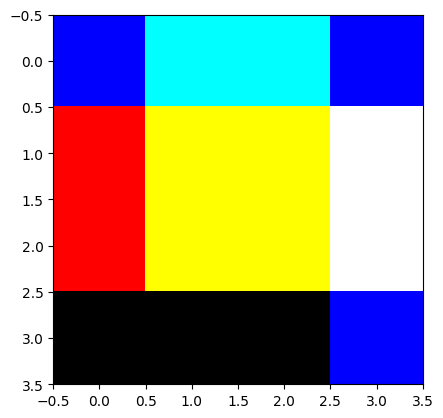

  6%|▌         | 1699/28000 [02:19<31:33, 13.89it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 4, 3)


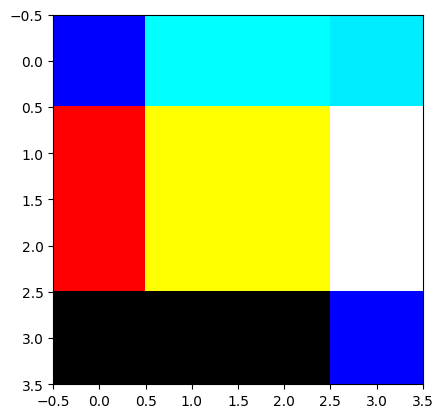

  6%|▌         | 1749/28000 [02:23<43:41, 10.02it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 4, 3)


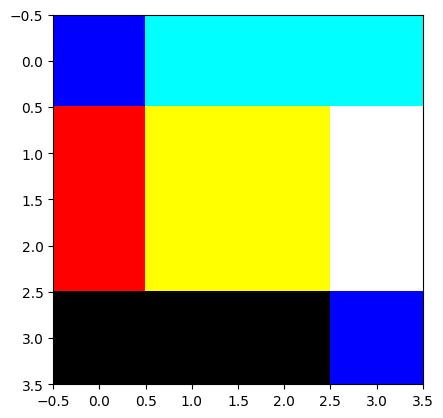

  6%|▋         | 1800/28000 [02:28<40:03, 10.90it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 4, 3)


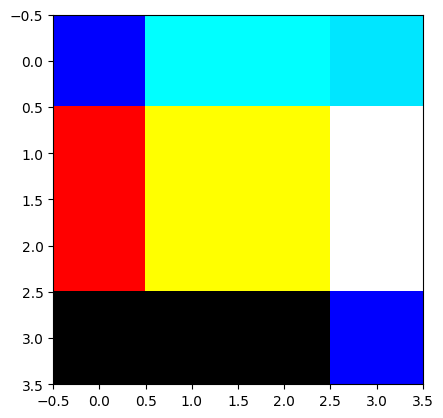

  7%|▋         | 1850/28000 [02:33<34:41, 12.56it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 4, 3)


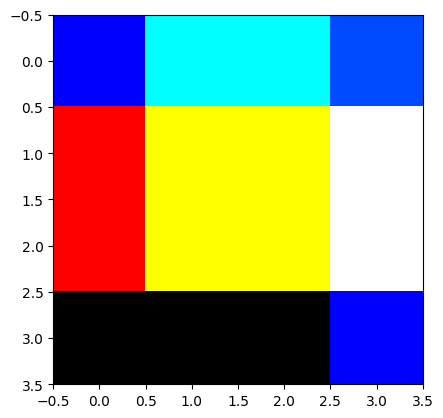

  7%|▋         | 1900/28000 [02:37<44:32,  9.77it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 4, 3)


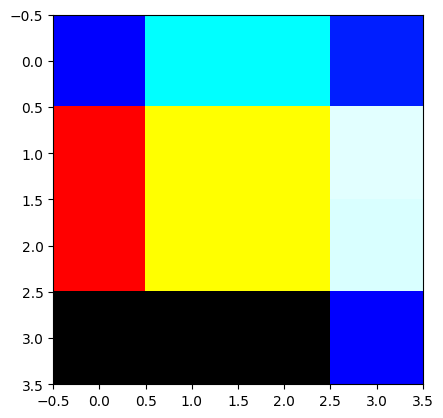

  7%|▋         | 1949/28000 [02:41<36:52, 11.77it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 4, 3)


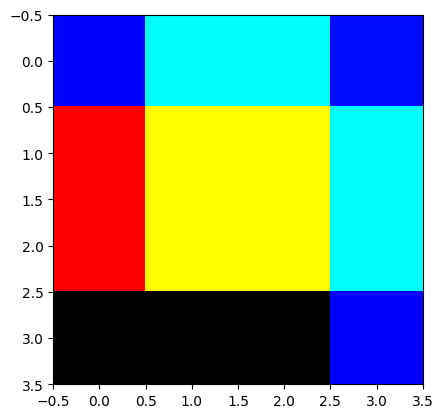

  7%|▋         | 1999/28000 [02:45<31:02, 13.96it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 4, 3)


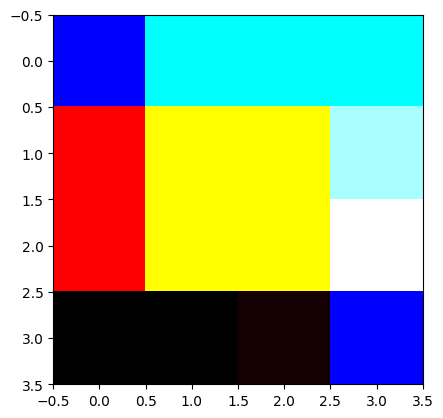

  7%|▋         | 2049/28000 [02:50<42:52, 10.09it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 4, 3)


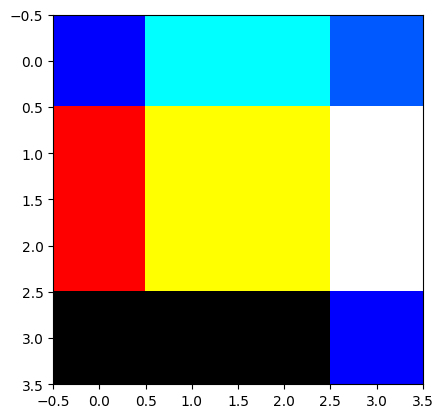

  7%|▋         | 2099/28000 [02:54<30:14, 14.27it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 4, 3)


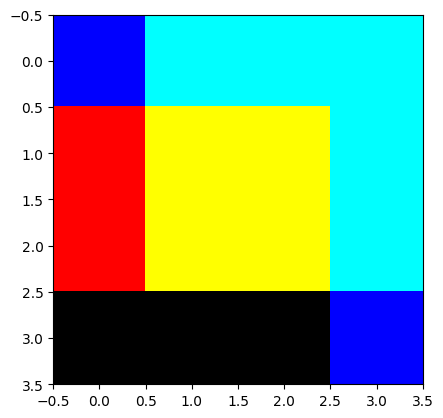

  8%|▊         | 2149/28000 [02:58<31:08, 13.83it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 4, 3)


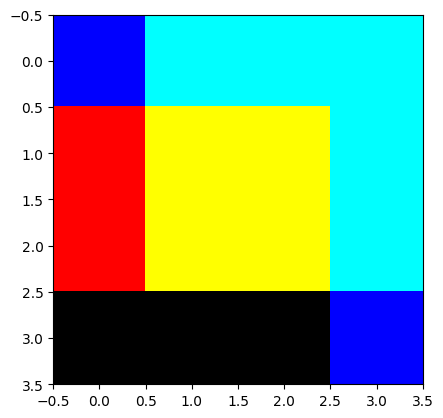

  8%|▊         | 2199/28000 [03:02<42:20, 10.15it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 4, 3)


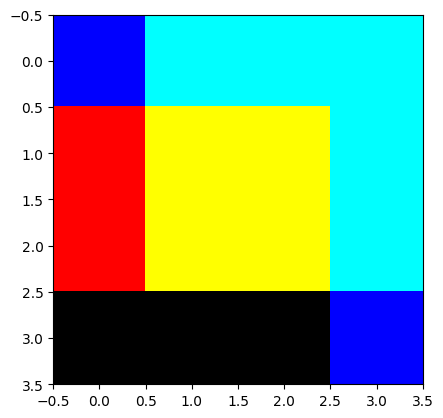

  8%|▊         | 2250/28000 [03:06<31:26, 13.65it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 4, 3)


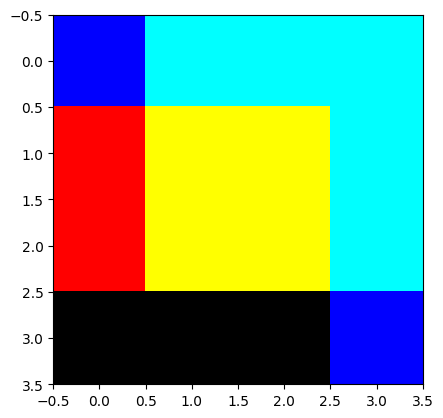

  8%|▊         | 2300/28000 [03:10<31:34, 13.57it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 4, 3)


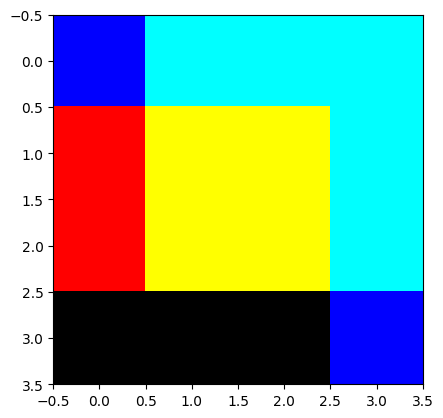

  8%|▊         | 2350/28000 [03:14<40:27, 10.57it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 4, 3)


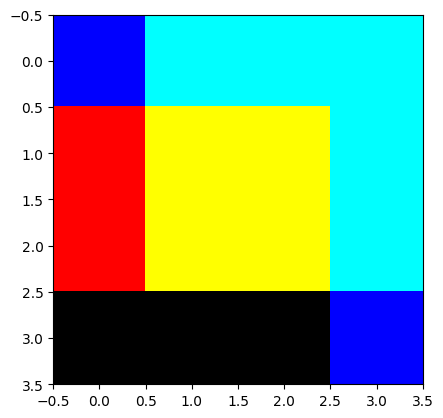

  9%|▊         | 2399/28000 [03:19<31:45, 13.44it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 4, 3)


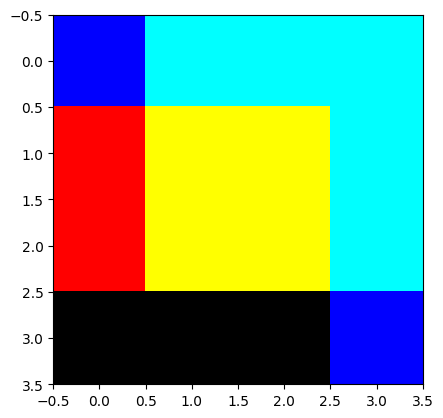

  9%|▊         | 2449/28000 [03:23<32:15, 13.20it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 4, 3)


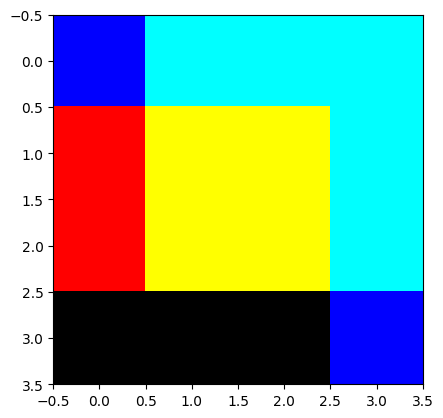

  9%|▉         | 2499/28000 [03:27<40:28, 10.50it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 4, 3)


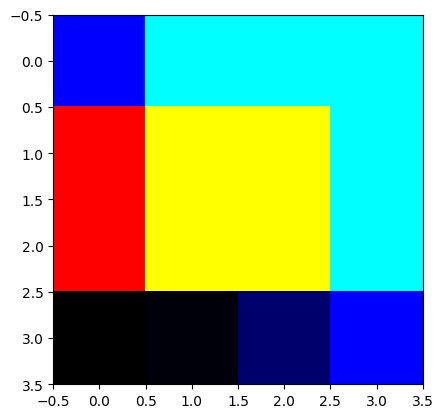

  9%|▉         | 2550/28000 [03:32<31:29, 13.47it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 4, 3)


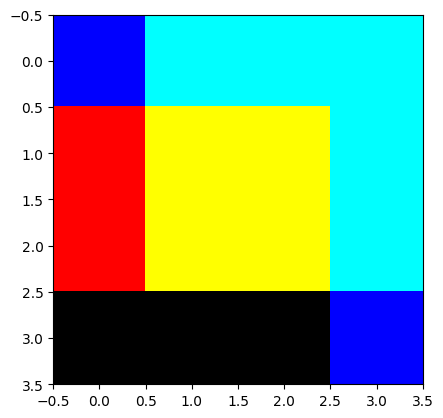

  9%|▉         | 2600/28000 [03:35<31:35, 13.40it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 4, 3)


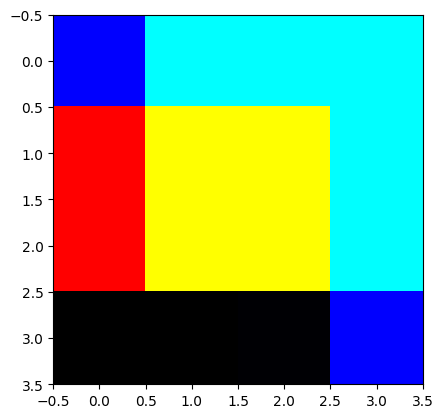

  9%|▉         | 2650/28000 [03:39<36:32, 11.56it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 4, 3)


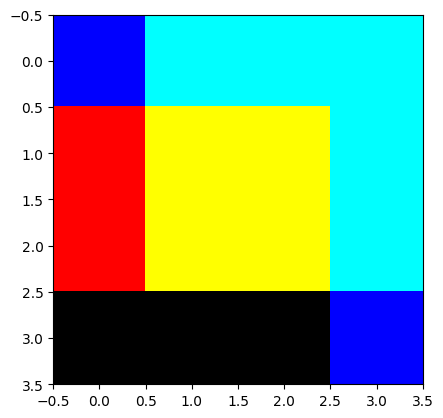

 10%|▉         | 2700/28000 [03:44<32:11, 13.10it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 4, 3)


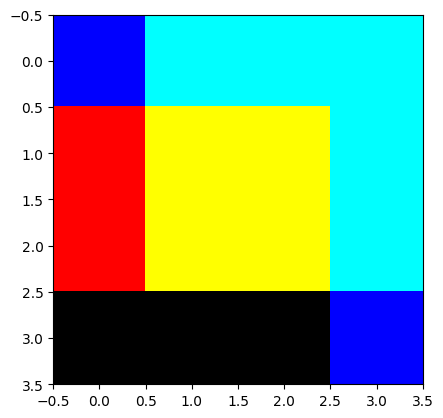

 10%|▉         | 2750/28000 [03:48<31:07, 13.52it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 4, 3)


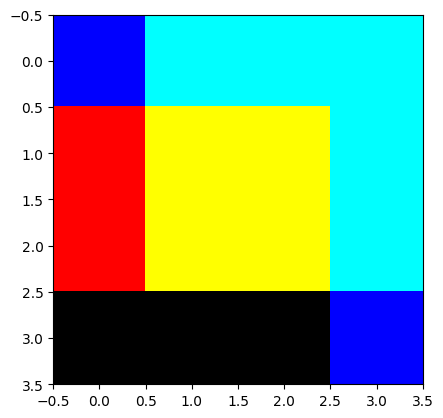

 10%|█         | 2800/28000 [03:52<30:45, 13.66it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 4, 3)


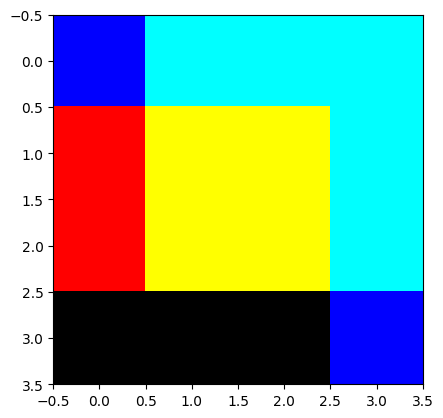

 10%|█         | 2849/28000 [04:00<48:00,  8.73it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 4, 3)


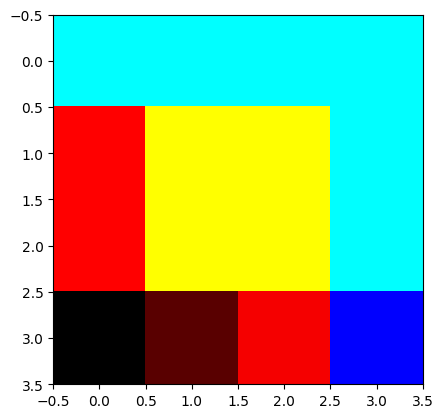

 10%|█         | 2899/28000 [04:04<31:41, 13.20it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 4, 3)


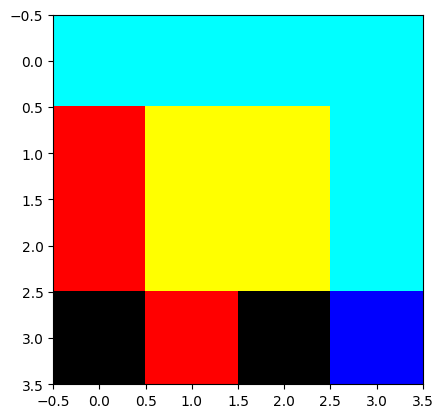

 11%|█         | 2949/28000 [04:08<41:39, 10.02it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 4, 3)


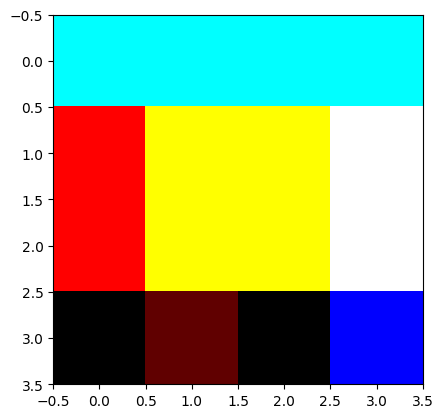

 11%|█         | 3000/28000 [04:13<31:12, 13.35it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 4, 3)


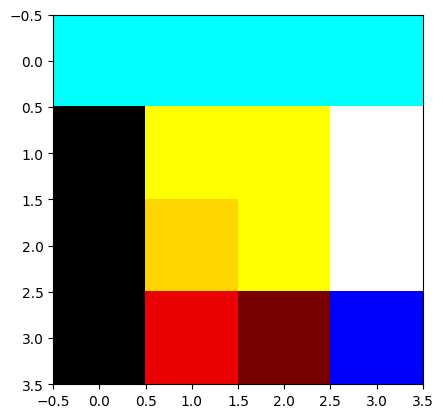

 11%|█         | 3050/28000 [04:17<31:39, 13.13it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 4, 3)


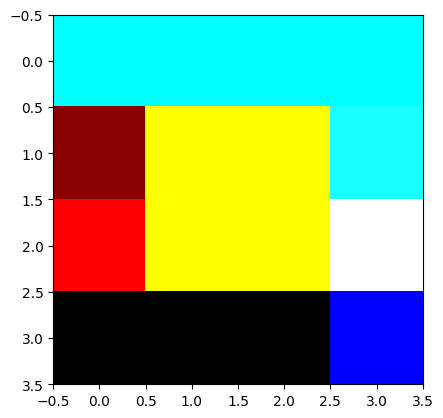

 11%|█         | 3100/28000 [04:21<41:37,  9.97it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 4, 3)


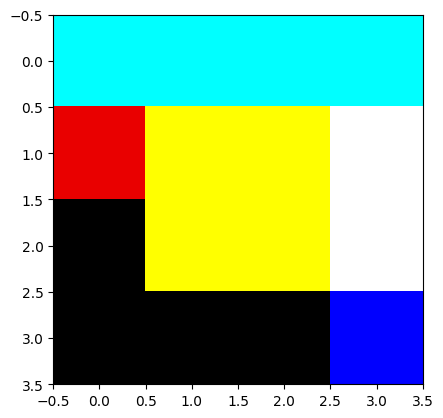

 11%|█         | 3149/28000 [04:26<31:58, 12.95it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 4, 3)


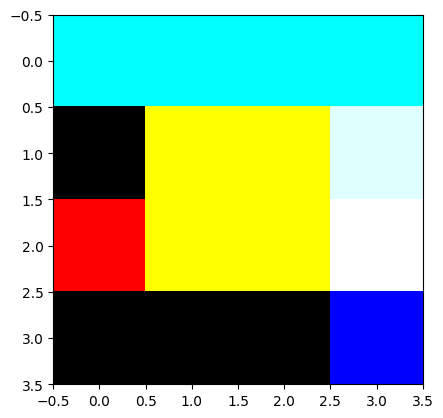

 11%|█▏        | 3199/28000 [04:30<32:03, 12.89it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 4, 3)


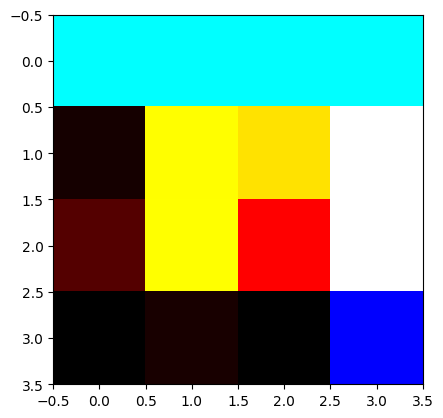

 12%|█▏        | 3249/28000 [04:34<39:23, 10.47it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 4, 3)


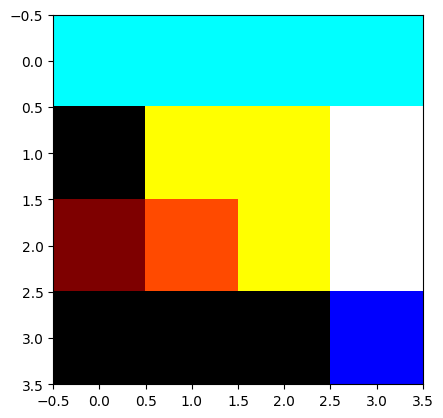

 12%|█▏        | 3300/28000 [04:39<31:26, 13.09it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 4, 3)


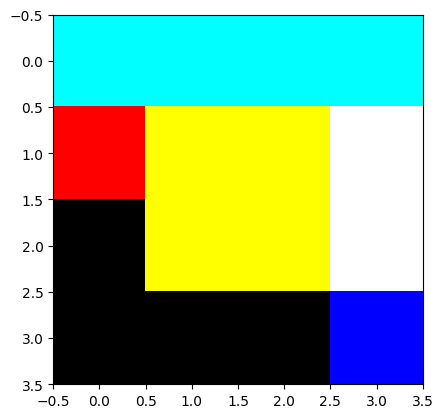

 12%|█▏        | 3350/28000 [04:43<31:15, 13.14it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 4, 3)


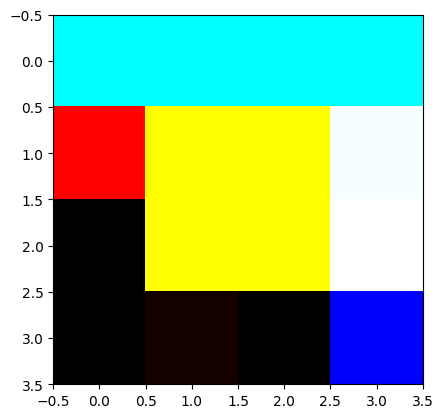

 12%|█▏        | 3400/28000 [04:48<40:26, 10.14it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 4, 3)


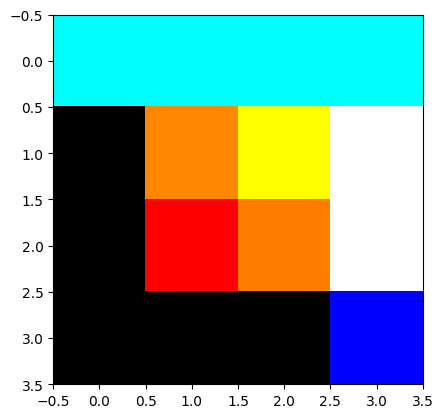

 12%|█▏        | 3450/28000 [04:52<30:52, 13.25it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 4, 3)


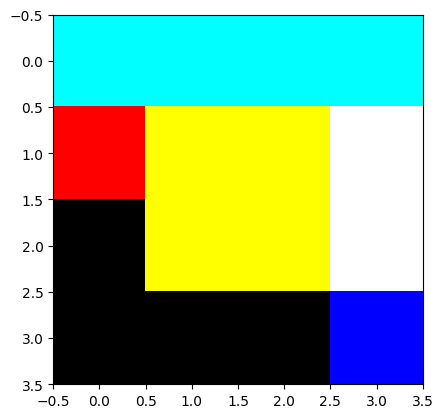

 12%|█▎        | 3500/28000 [04:56<32:24, 12.60it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 4, 3)


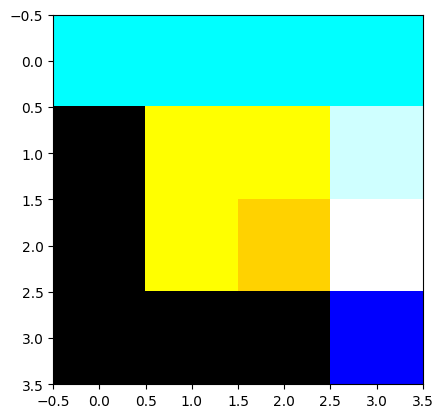

 13%|█▎        | 3550/28000 [05:01<41:42,  9.77it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 4, 3)


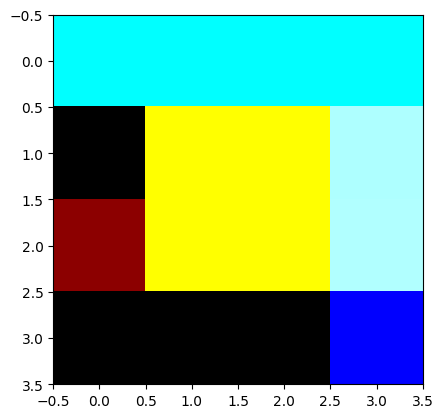

 13%|█▎        | 3599/28000 [05:05<31:52, 12.76it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 4, 3)


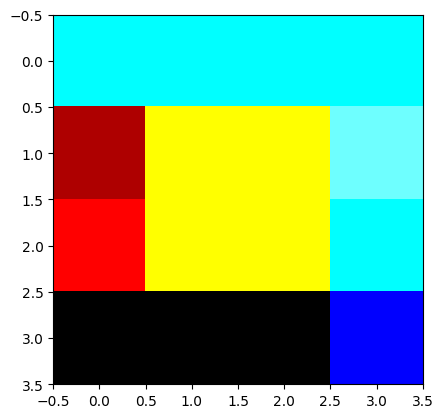

 13%|█▎        | 3649/28000 [05:10<31:29, 12.89it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 4, 3)


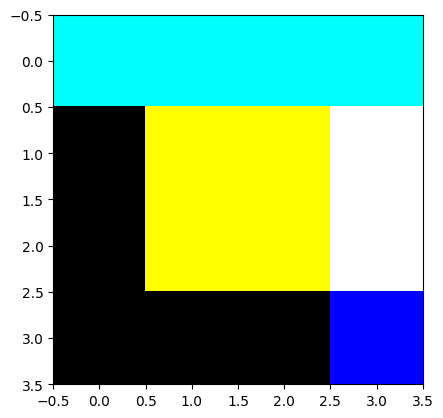

 13%|█▎        | 3699/28000 [05:14<37:50, 10.70it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 4, 3)


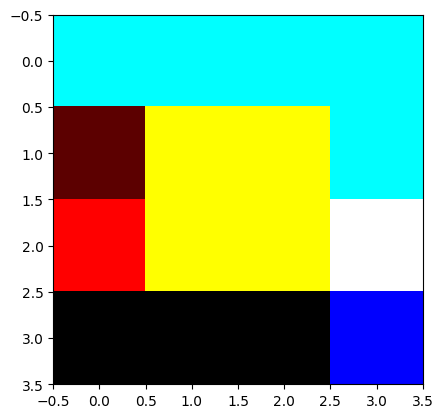

 13%|█▎        | 3749/28000 [05:19<31:03, 13.01it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 4, 3)


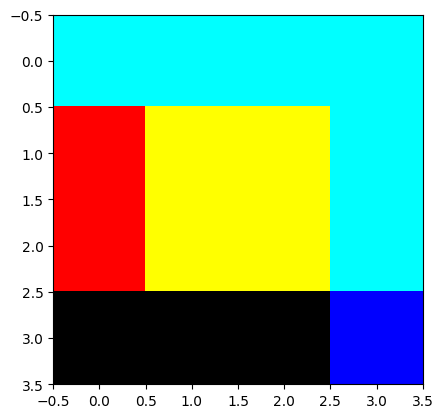

 14%|█▎        | 3800/28000 [05:25<1:05:40,  6.14it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 4, 3)


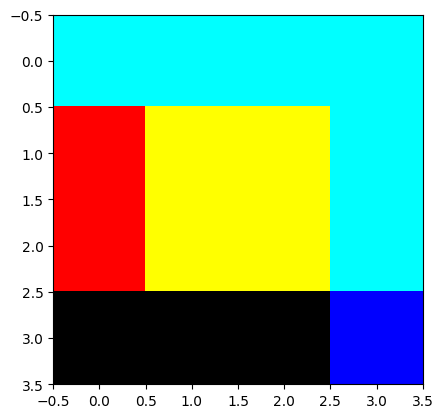

 14%|█▍        | 3850/28000 [05:32<31:52, 12.63it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 4, 3)


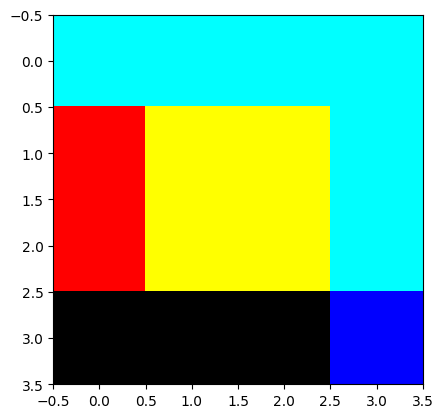

 14%|█▍        | 3900/28000 [05:38<1:24:28,  4.76it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 4, 3)


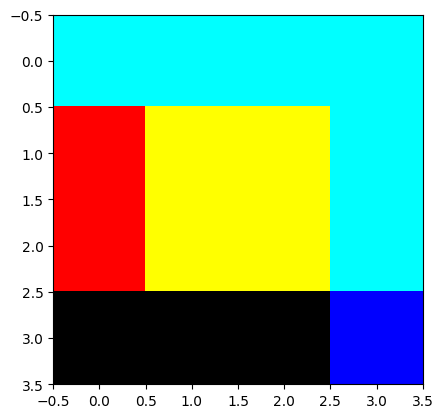

 14%|█▍        | 3949/28000 [05:45<31:03, 12.90it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 4, 3)


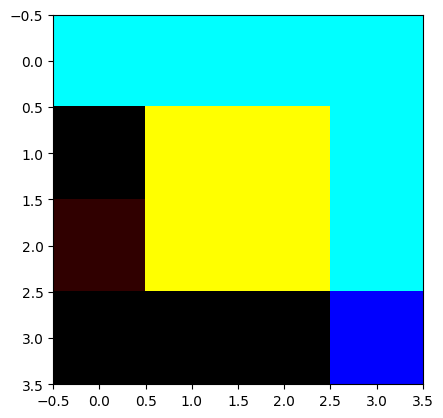

 14%|█▍        | 3999/28000 [05:49<31:17, 12.78it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 4, 3)


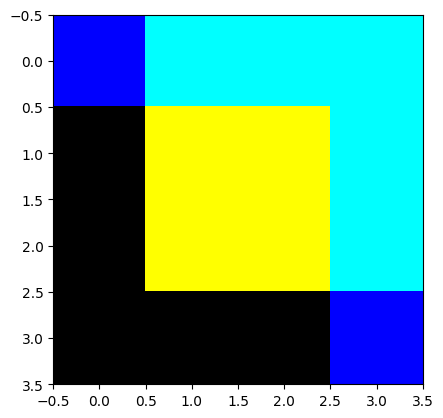

 14%|█▍        | 4049/28000 [05:53<30:37, 13.03it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 4, 3)


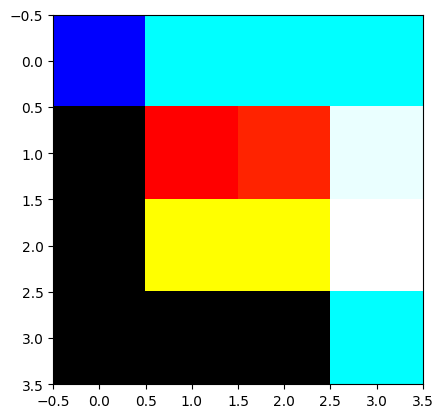

 15%|█▍        | 4100/28000 [05:58<31:44, 12.55it/s]

(4, 4, 3)


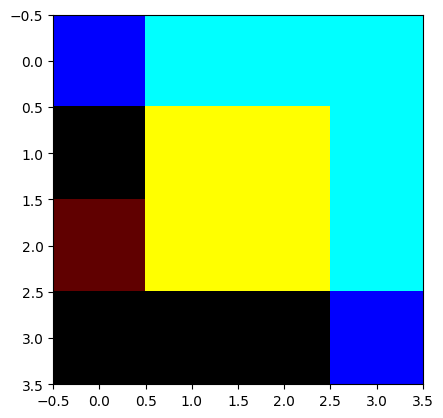

 15%|█▍        | 4149/28000 [06:03<31:55, 12.45it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 4, 3)


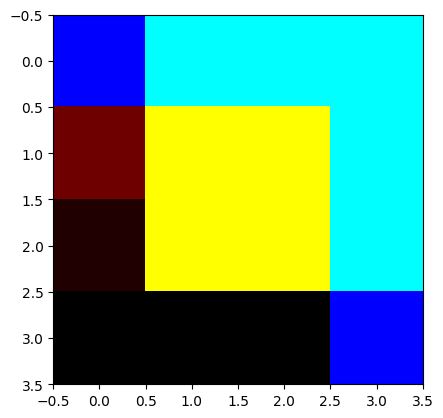

 15%|█▍        | 4199/28000 [06:07<38:33, 10.29it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 4, 3)


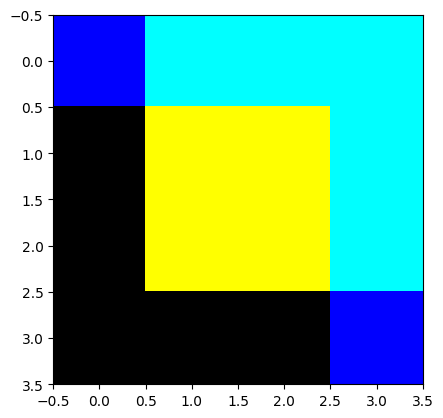

 15%|█▌        | 4250/28000 [06:12<31:55, 12.40it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 4, 3)


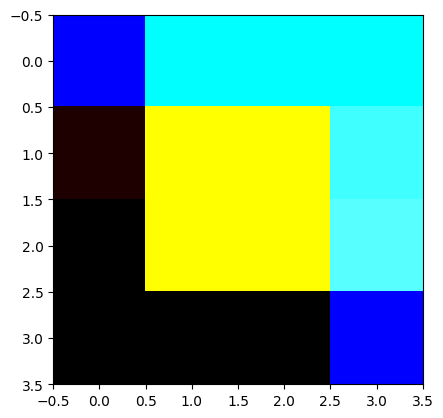

 15%|█▌        | 4300/28000 [06:16<29:31, 13.37it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 4, 3)


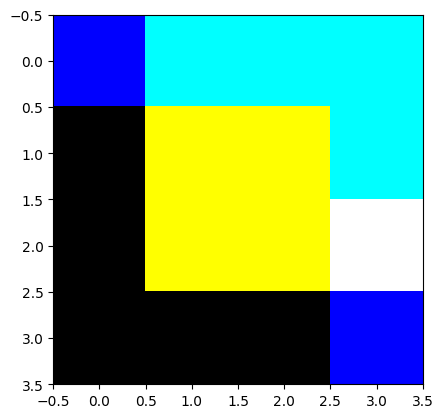

 16%|█▌        | 4350/28000 [06:20<39:56,  9.87it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 4, 3)


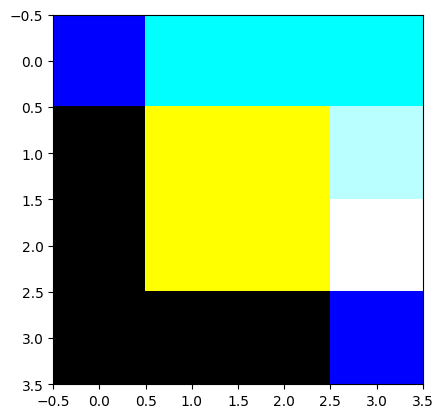

 16%|█▌        | 4399/28000 [06:25<30:15, 13.00it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 4, 3)


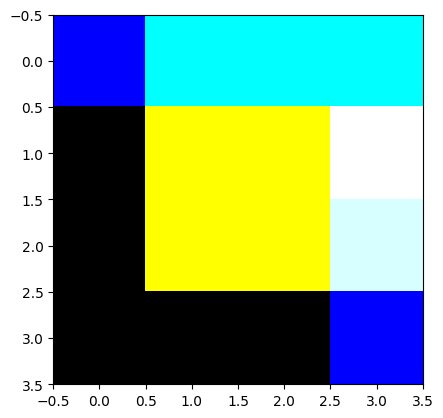

 16%|█▌        | 4449/28000 [06:29<30:51, 12.72it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 4, 3)


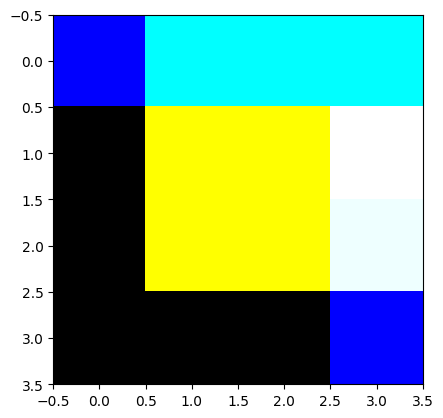

 16%|█▌        | 4499/28000 [06:34<37:43, 10.38it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 4, 3)


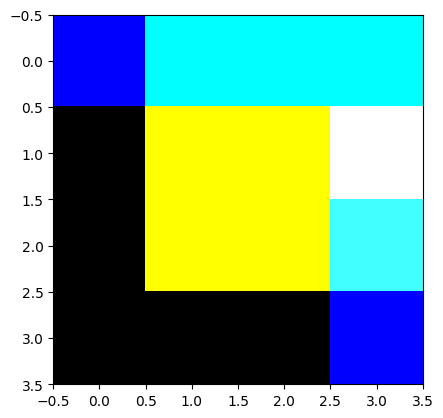

 16%|█▌        | 4549/28000 [06:38<30:35, 12.77it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 4, 3)


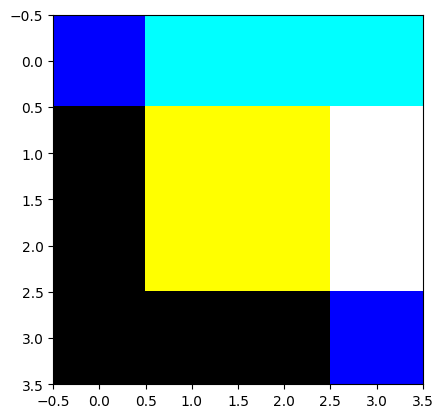

 16%|█▋        | 4599/28000 [06:43<30:03, 12.97it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 4, 3)


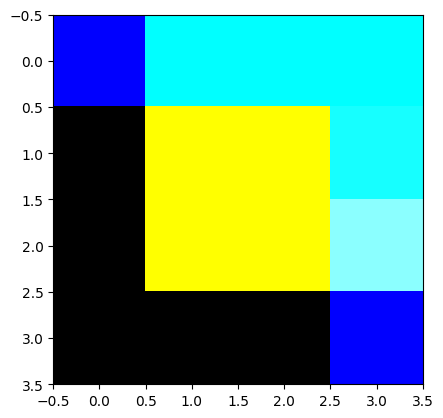

 17%|█▋        | 4649/28000 [06:47<36:40, 10.61it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 4, 3)


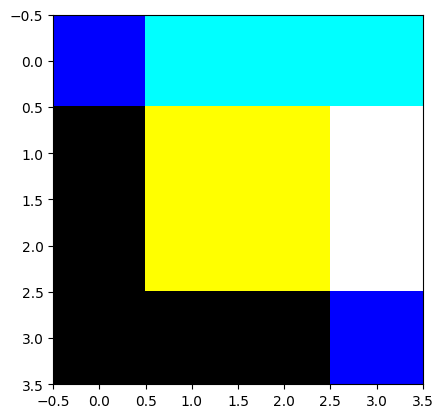

 17%|█▋        | 4700/28000 [06:52<29:58, 12.95it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 4, 3)


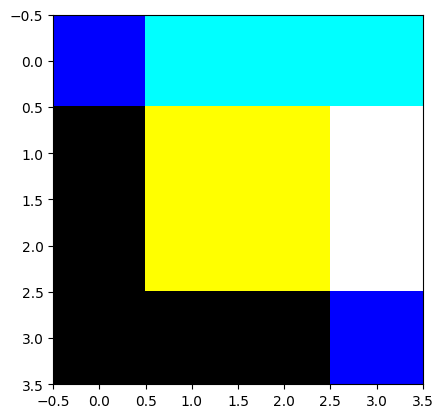

 17%|█▋        | 4750/28000 [06:56<29:47, 13.01it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 4, 3)


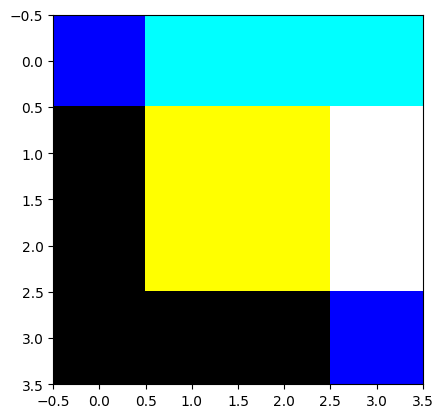

 17%|█▋        | 4800/28000 [07:00<36:09, 10.69it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 4, 3)


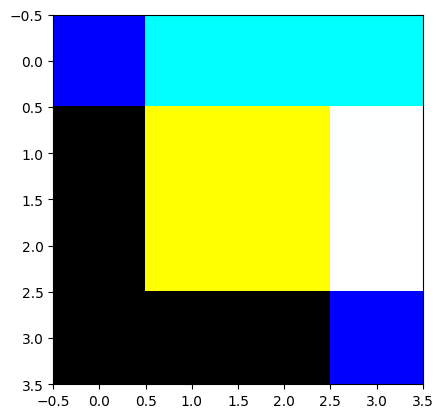

 17%|█▋        | 4850/28000 [07:05<29:32, 13.06it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 4, 3)


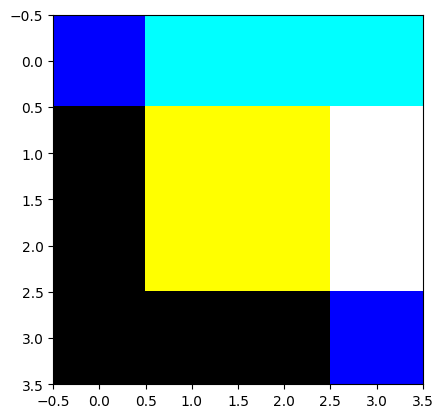

 18%|█▊        | 4900/28000 [07:09<29:32, 13.03it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 4, 3)


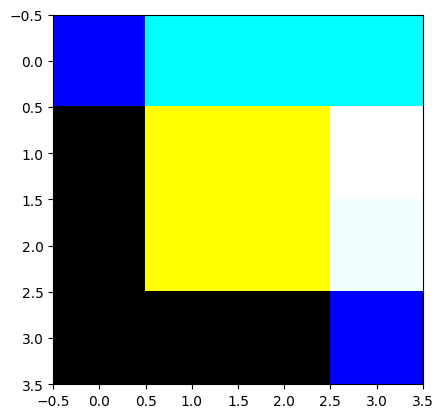

 18%|█▊        | 4950/28000 [07:13<32:47, 11.71it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 4, 3)


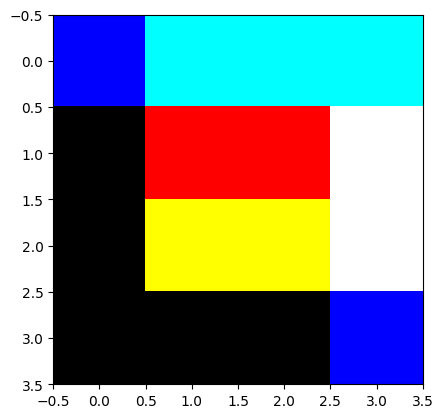

 18%|█▊        | 4999/28000 [07:18<29:10, 13.14it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 4, 3)


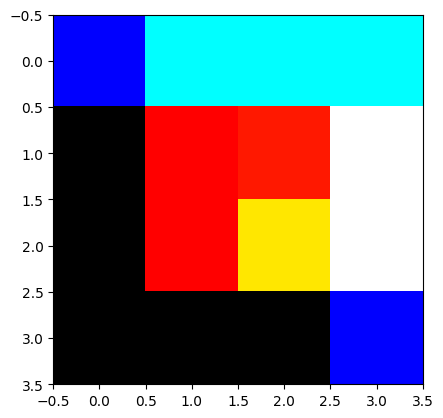

 18%|█▊        | 5049/28000 [07:22<29:42, 12.88it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 4, 3)


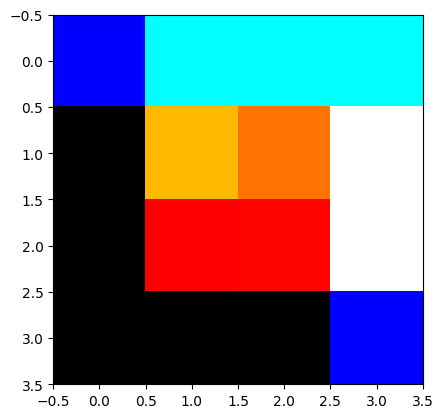

 18%|█▊        | 5099/28000 [07:26<28:33, 13.36it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 4, 3)


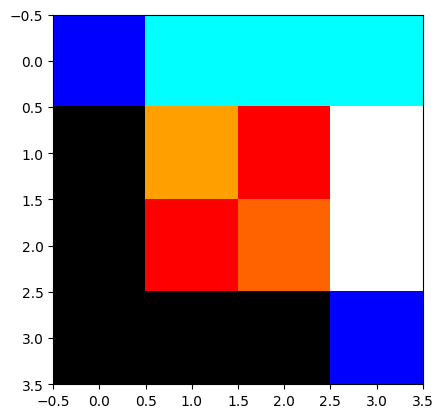

 18%|█▊        | 5149/28000 [07:31<29:10, 13.06it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 4, 3)


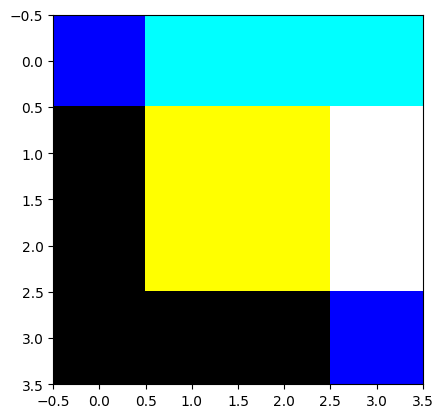

 19%|█▊        | 5199/28000 [07:36<29:33, 12.85it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 4, 3)


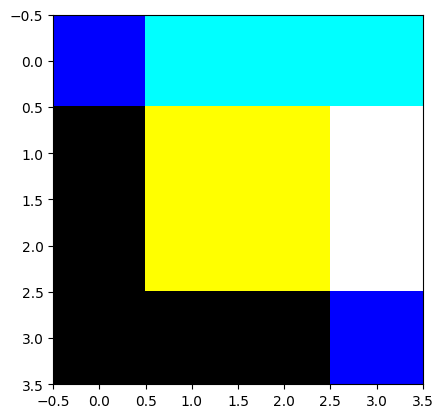

 19%|█▊        | 5249/28000 [07:40<29:05, 13.03it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 4, 3)


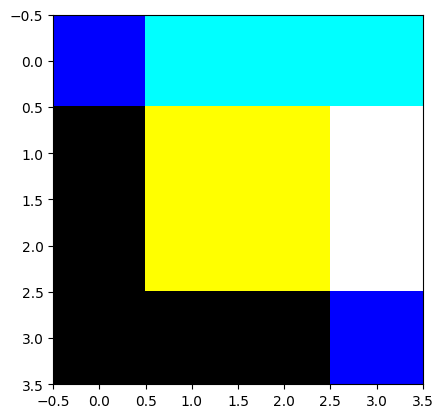

 19%|█▉        | 5300/28000 [07:45<29:20, 12.89it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 4, 3)


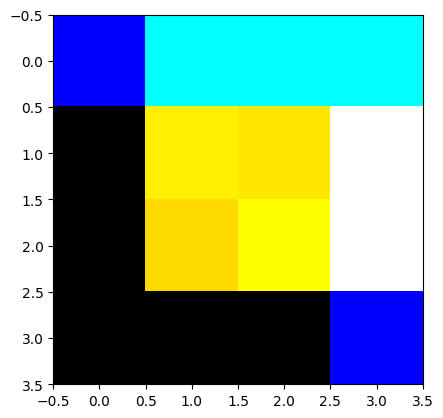

 19%|█▉        | 5350/28000 [07:49<28:53, 13.07it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 4, 3)


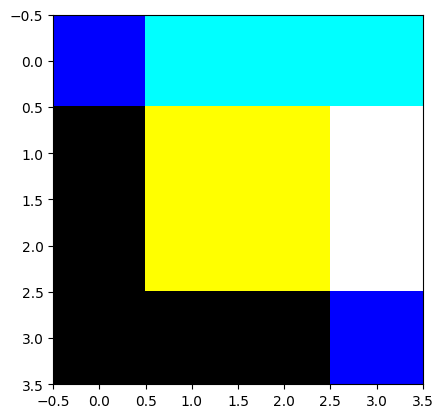

 19%|█▉        | 5400/28000 [07:53<28:56, 13.01it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 4, 3)


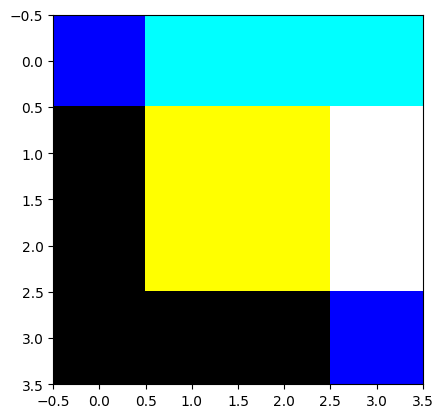

 19%|█▉        | 5450/28000 [07:58<28:53, 13.01it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 4, 3)


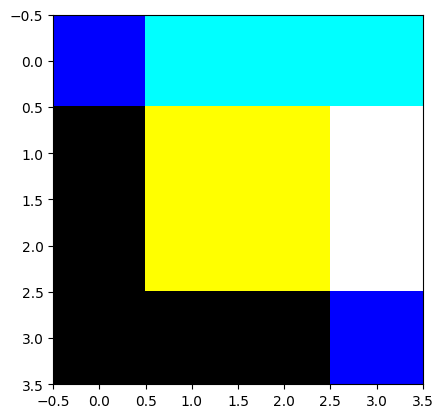

 20%|█▉        | 5500/28000 [08:02<28:51, 12.99it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 4, 3)


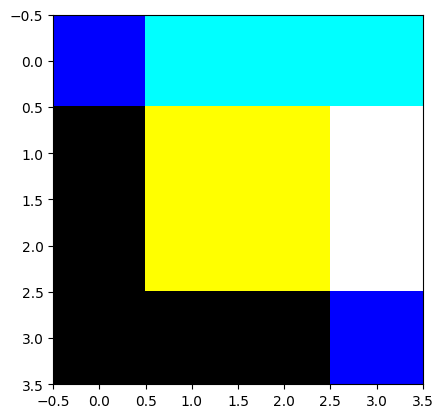

 20%|█▉        | 5550/28000 [08:06<28:56, 12.93it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 4, 3)


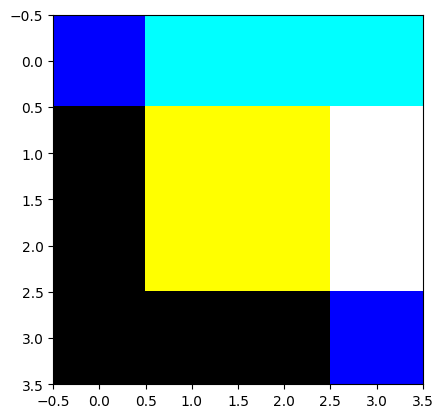

 20%|██        | 5600/28000 [08:11<29:59, 12.45it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 4, 3)


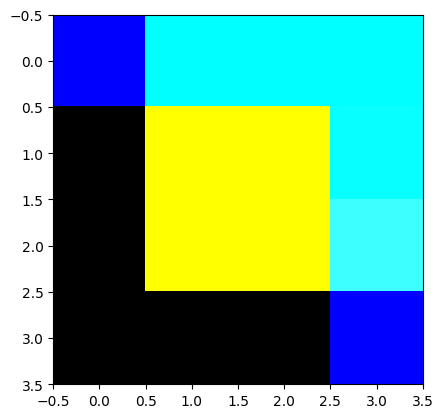

 20%|██        | 5650/28000 [08:16<29:10, 12.77it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 4, 3)


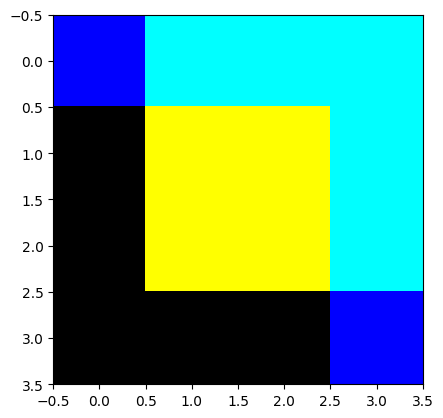

 20%|██        | 5700/28000 [08:20<29:19, 12.67it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 4, 3)


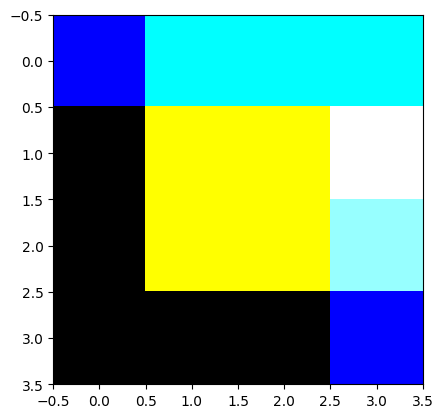

 21%|██        | 5749/28000 [08:25<30:10, 12.29it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 4, 3)


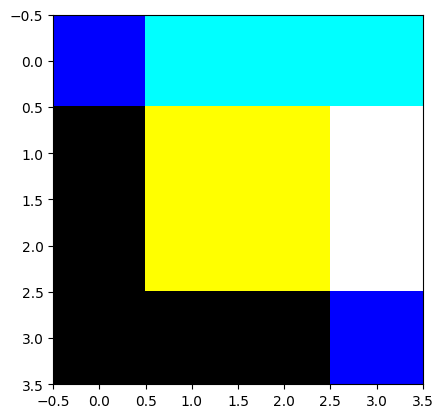

 21%|██        | 5799/28000 [08:29<28:24, 13.02it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 4, 3)


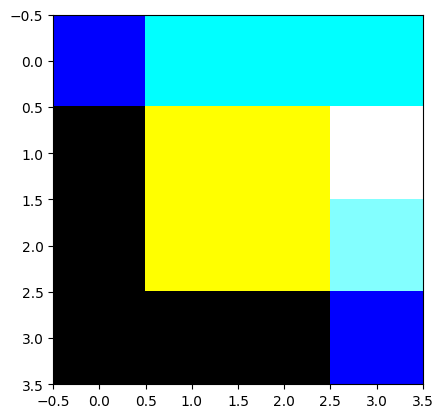

 21%|██        | 5849/28000 [08:33<28:28, 12.97it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 4, 3)


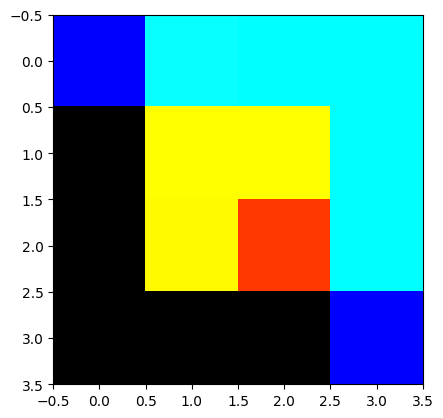

 21%|██        | 5900/28000 [08:38<29:25, 12.52it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 4, 3)


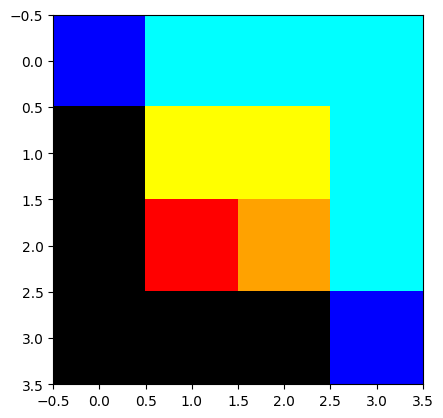

 21%|██▏       | 5950/28000 [08:42<28:16, 13.00it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 4, 3)


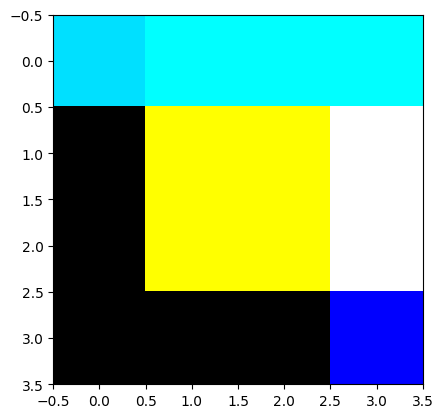

 21%|██▏       | 6000/28000 [08:47<28:39, 12.79it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 4, 3)


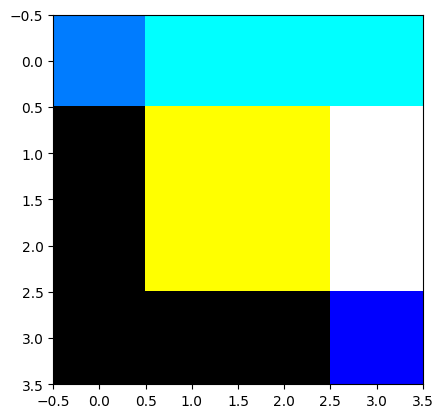

 22%|██▏       | 6049/28000 [08:52<28:31, 12.82it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 4, 3)


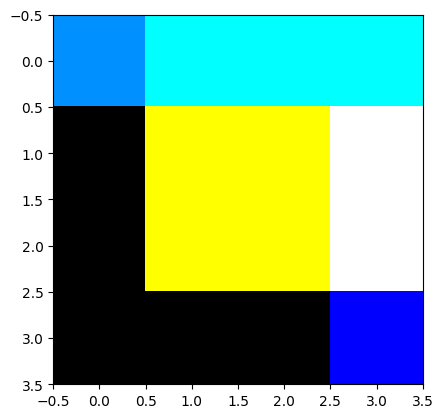

 22%|██▏       | 6099/28000 [08:56<28:31, 12.79it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 4, 3)


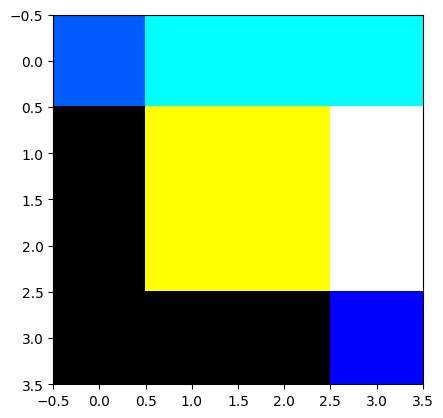

 22%|██▏       | 6149/28000 [09:00<28:44, 12.67it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 4, 3)


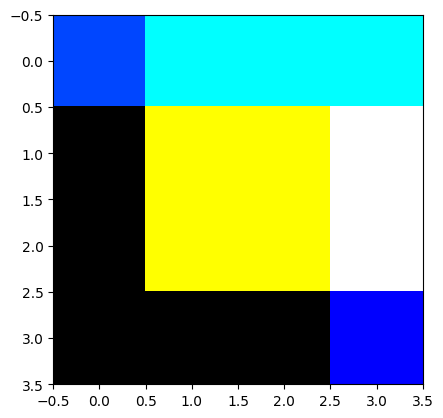

 22%|██▏       | 6200/28000 [09:05<29:17, 12.40it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 4, 3)


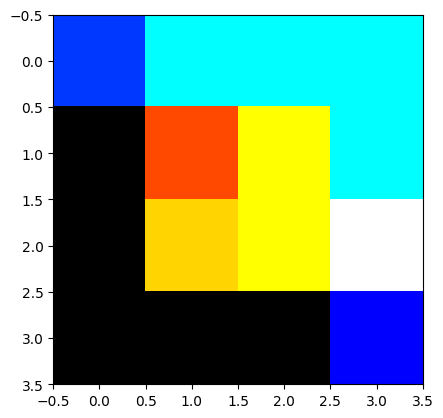

 22%|██▏       | 6250/28000 [09:09<27:50, 13.02it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 4, 3)


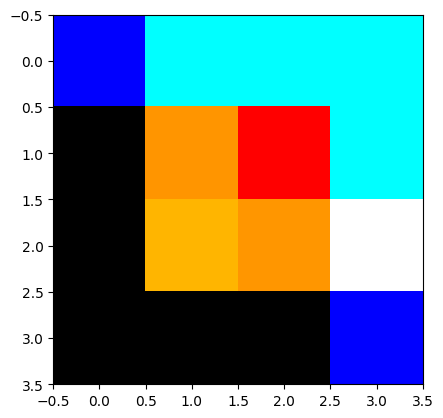

 22%|██▎       | 6300/28000 [09:13<28:21, 12.76it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 4, 3)


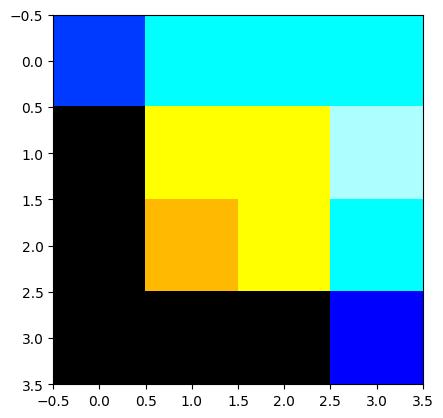

 23%|██▎       | 6350/28000 [09:18<28:00, 12.88it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 4, 3)


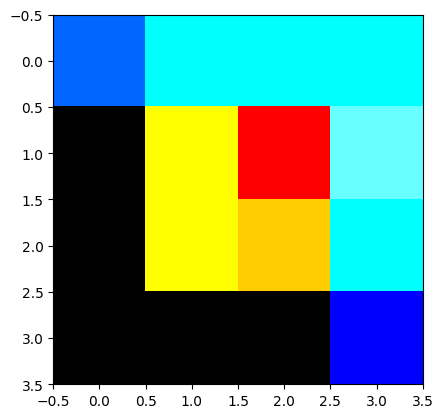

 23%|██▎       | 6400/28000 [09:22<27:22, 13.15it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 4, 3)


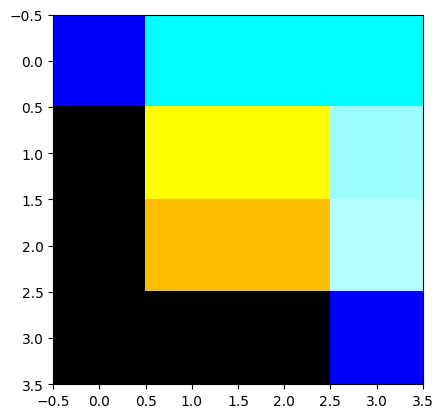

 23%|██▎       | 6450/28000 [09:26<27:36, 13.01it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 4, 3)


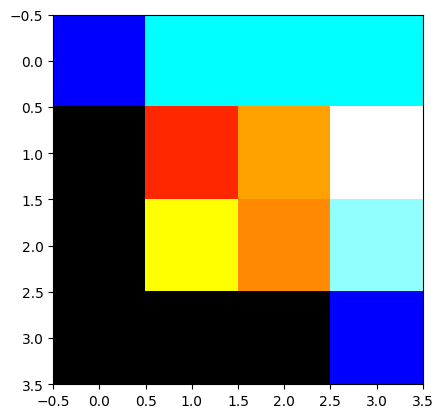

 23%|██▎       | 6500/28000 [09:32<37:49,  9.47it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 4, 3)


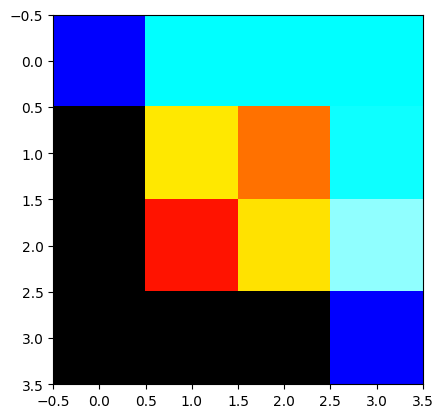

 23%|██▎       | 6549/28000 [09:37<27:54, 12.81it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 4, 3)


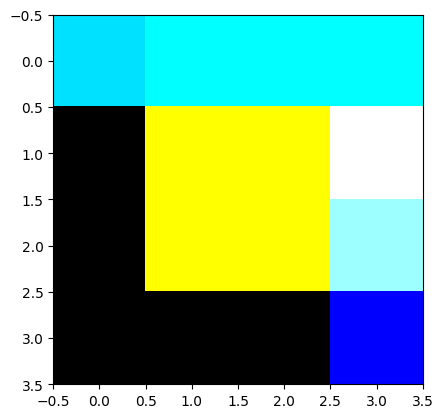

 24%|██▎       | 6599/28000 [09:41<27:01, 13.20it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 4, 3)


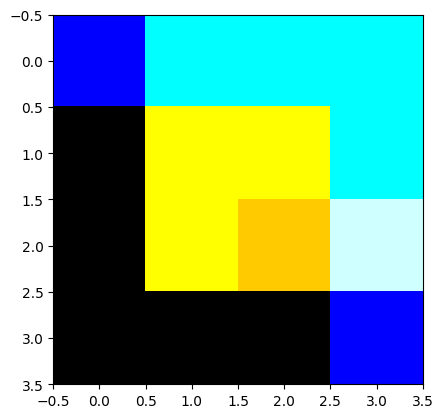

 24%|██▍       | 6650/28000 [09:45<37:06,  9.59it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 4, 3)


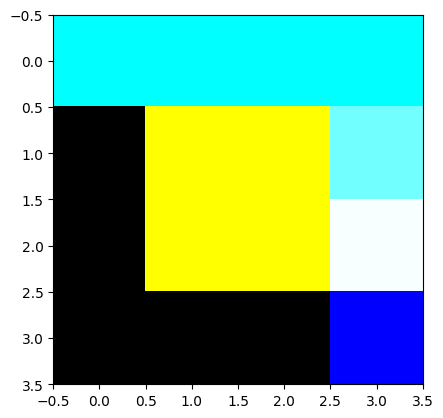

 24%|██▍       | 6699/28000 [09:50<28:59, 12.25it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 4, 3)


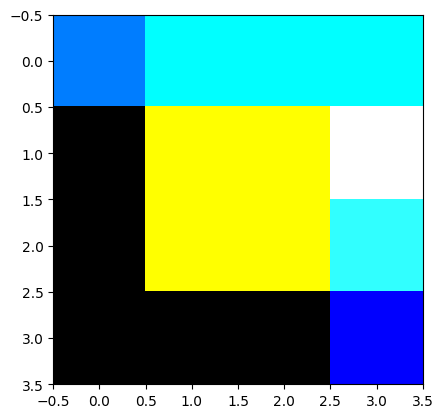

 24%|██▍       | 6749/28000 [09:54<27:02, 13.10it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 4, 3)


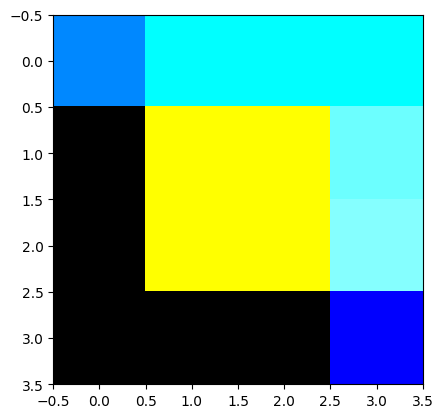

 24%|██▍       | 6800/28000 [09:59<36:16,  9.74it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 4, 3)


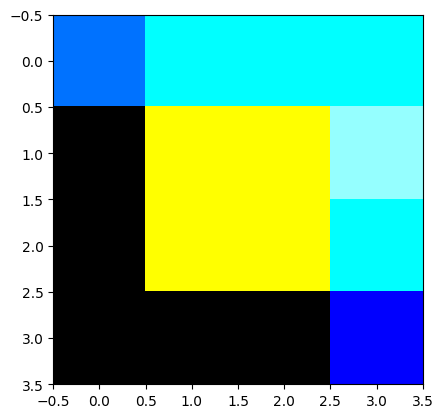

 24%|██▍       | 6849/28000 [10:03<27:05, 13.01it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 4, 3)


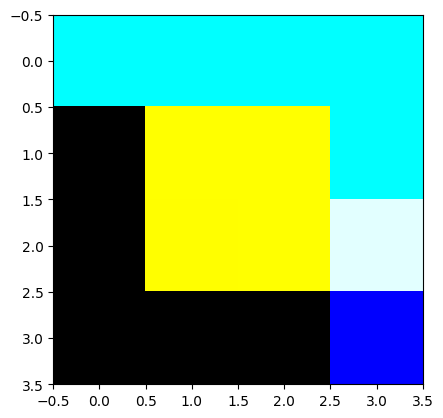

 25%|██▍       | 6899/28000 [10:07<27:56, 12.59it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 4, 3)


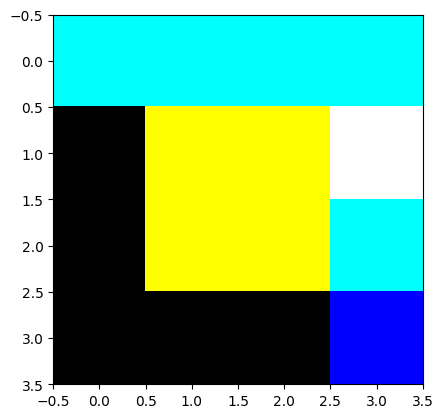

 25%|██▍       | 6950/28000 [10:12<36:42,  9.56it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 4, 3)


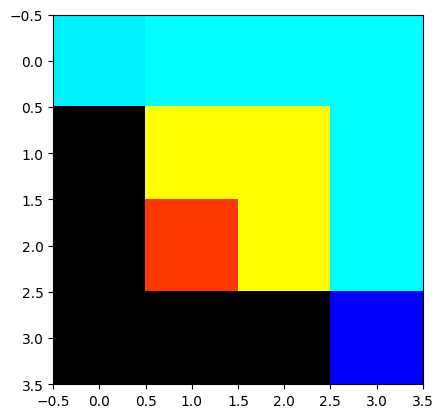

 25%|██▌       | 7000/28000 [10:16<27:28, 12.74it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 4, 3)


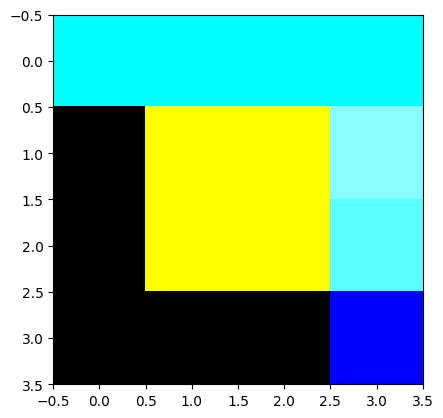

 25%|██▌       | 7050/28000 [10:20<26:28, 13.19it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 4, 3)


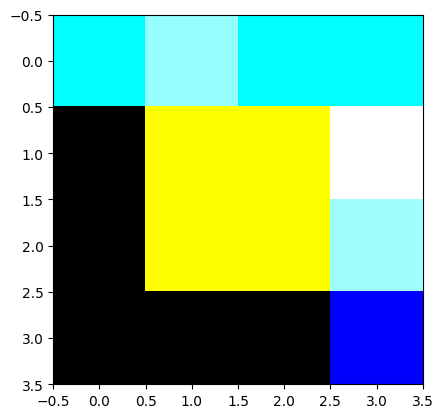

 25%|██▌       | 7100/28000 [10:25<39:03,  8.92it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 4, 3)


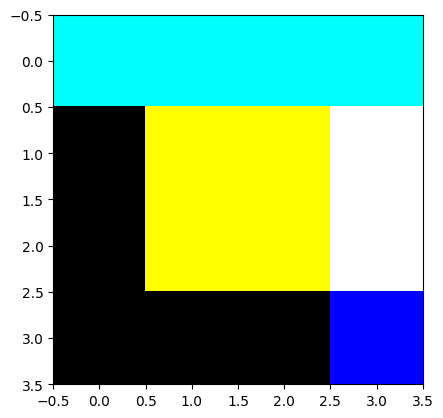

 26%|██▌       | 7150/28000 [10:29<26:27, 13.14it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 4, 3)


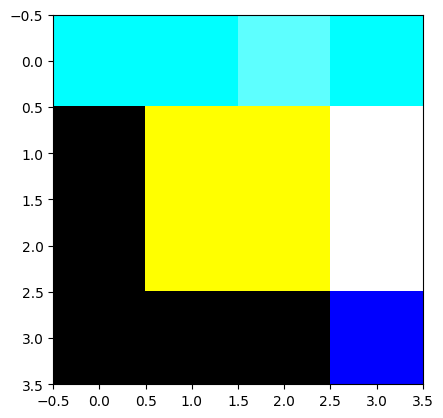

 26%|██▌       | 7200/28000 [10:34<27:14, 12.73it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 4, 3)


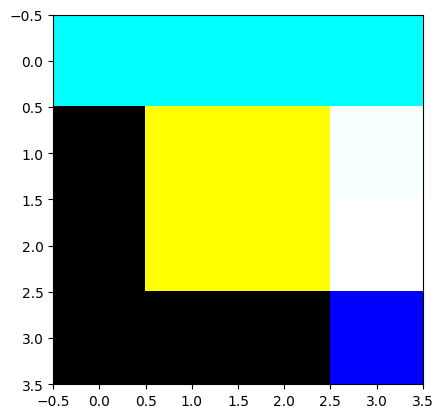

 26%|██▌       | 7250/28000 [10:38<34:08, 10.13it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 4, 3)


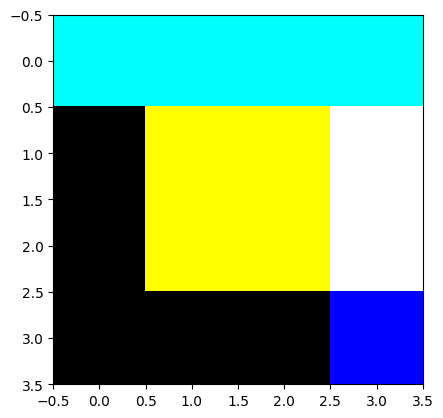

 26%|██▌       | 7300/28000 [10:43<26:33, 12.99it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 4, 3)


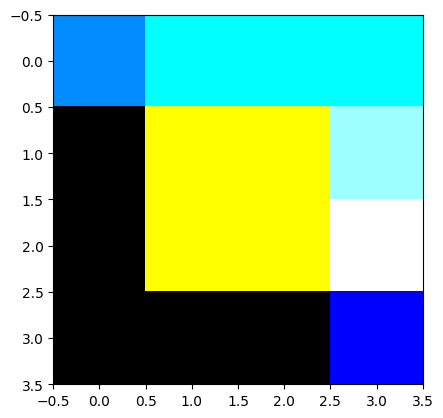

 26%|██▋       | 7350/28000 [10:47<26:07, 13.17it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 4, 3)


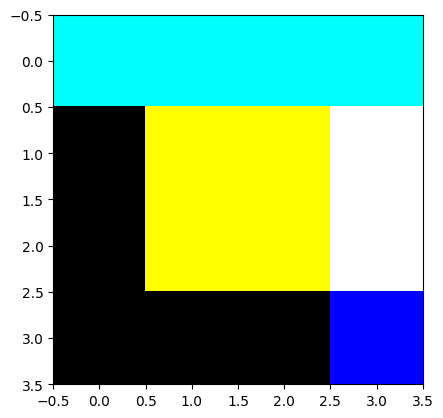

 26%|██▋       | 7400/28000 [10:51<34:38,  9.91it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 4, 3)


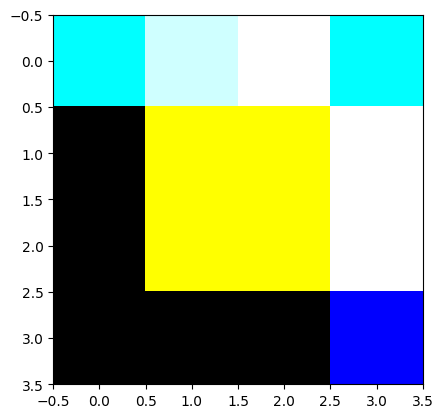

 27%|██▋       | 7449/28000 [10:56<26:43, 12.82it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 4, 3)


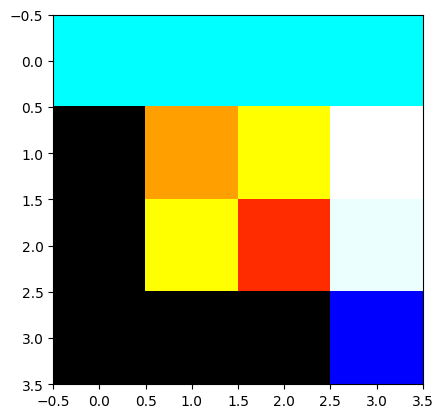

 27%|██▋       | 7499/28000 [11:00<25:54, 13.19it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 4, 3)


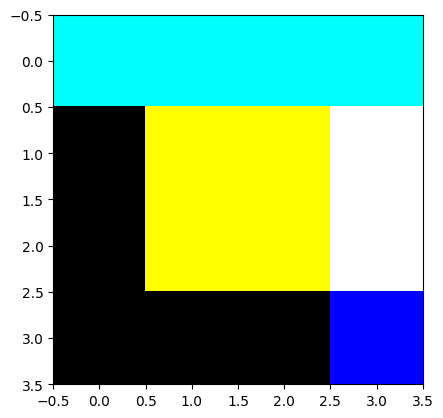

 27%|██▋       | 7549/28000 [11:04<34:10,  9.97it/s]

(4, 4, 3)


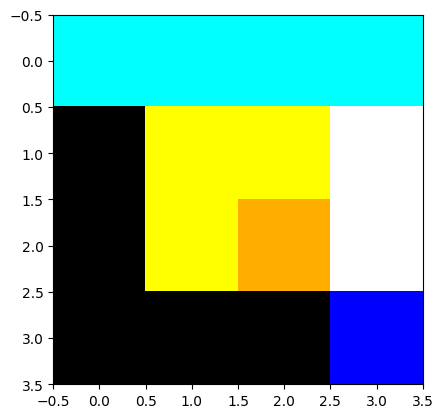

 27%|██▋       | 7600/28000 [11:09<26:08, 13.01it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 4, 3)


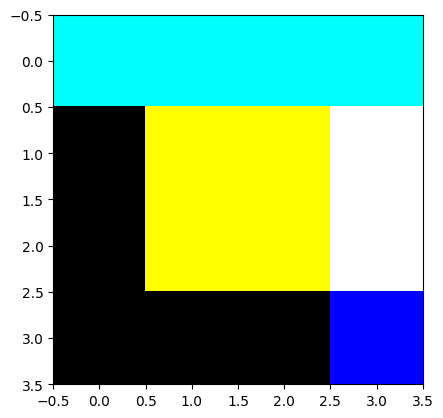

 27%|██▋       | 7650/28000 [11:13<26:11, 12.95it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 4, 3)


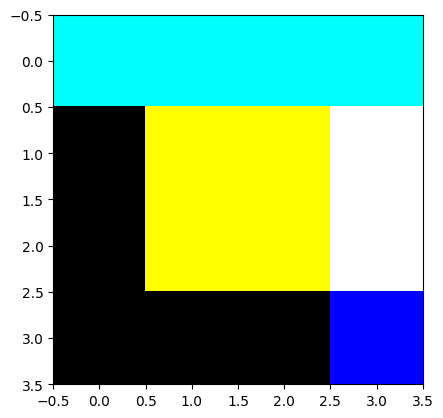

 28%|██▊       | 7700/28000 [11:17<33:49, 10.00it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 4, 3)


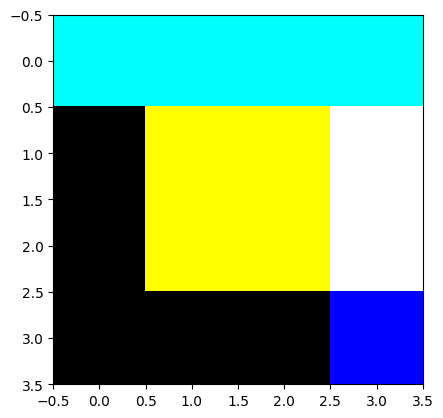

 28%|██▊       | 7750/28000 [11:22<25:50, 13.06it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 4, 3)


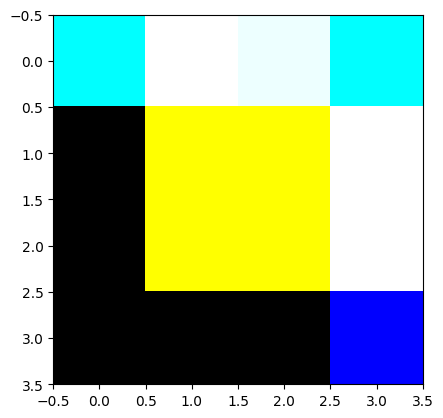

 28%|██▊       | 7800/28000 [11:26<26:08, 12.88it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 4, 3)


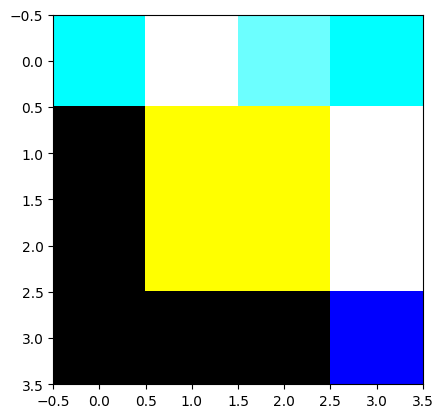

 28%|██▊       | 7850/28000 [11:30<32:03, 10.47it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 4, 3)


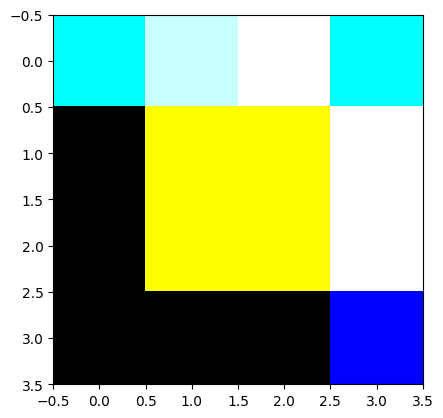

 28%|██▊       | 7899/28000 [11:35<26:26, 12.67it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 4, 3)


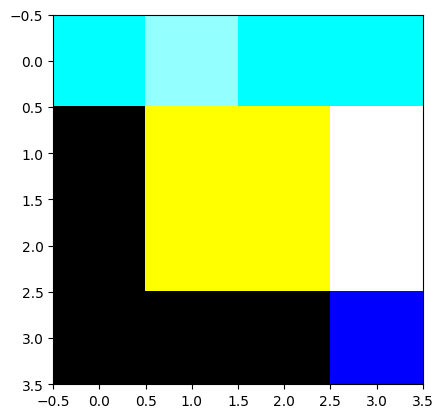

 28%|██▊       | 7949/28000 [11:39<26:50, 12.45it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 4, 3)


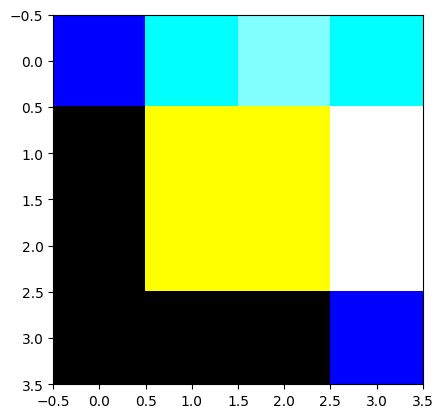

 29%|██▊       | 7999/28000 [11:44<34:01,  9.80it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 4, 3)


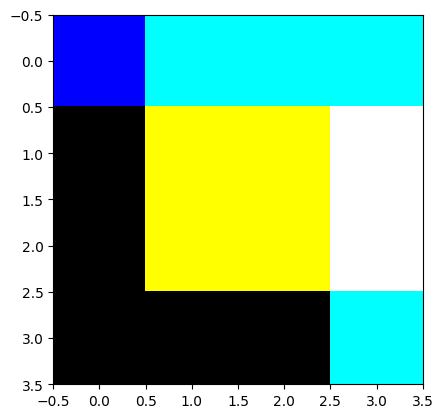

 29%|██▊       | 8049/28000 [11:48<25:39, 12.96it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 4, 3)


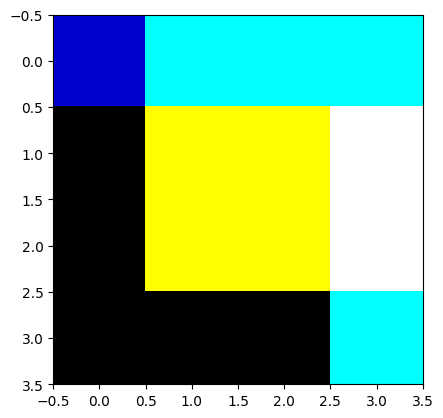

 29%|██▉       | 8099/28000 [11:52<25:14, 13.14it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 4, 3)


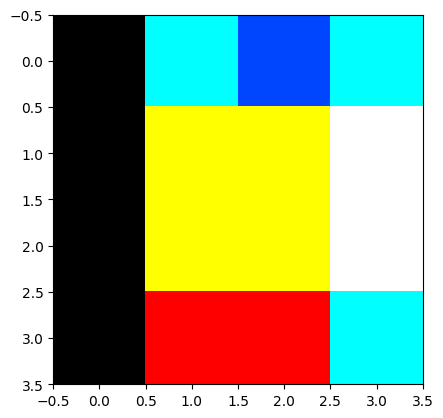

 29%|██▉       | 8149/28000 [11:57<28:39, 11.55it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 4, 3)


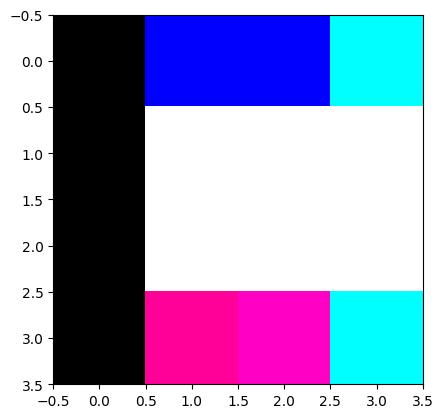

 29%|██▉       | 8199/28000 [12:02<25:33, 12.91it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 4, 3)


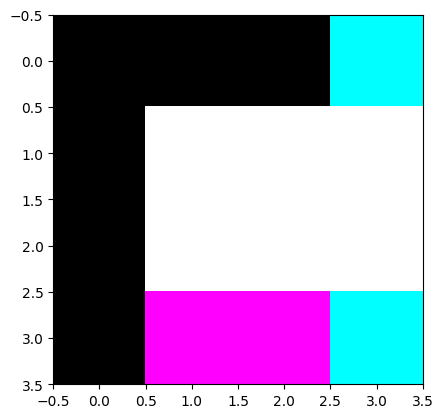

 29%|██▉       | 8249/28000 [12:06<25:36, 12.86it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 4, 3)


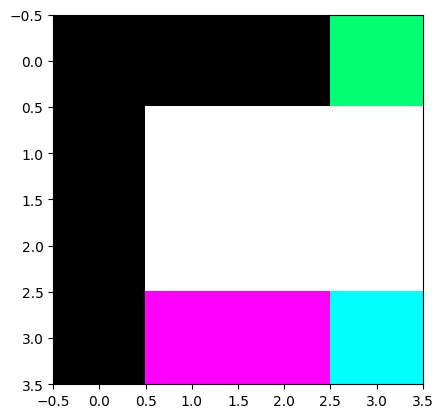

 30%|██▉       | 8299/28000 [12:10<26:01, 12.62it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 4, 3)


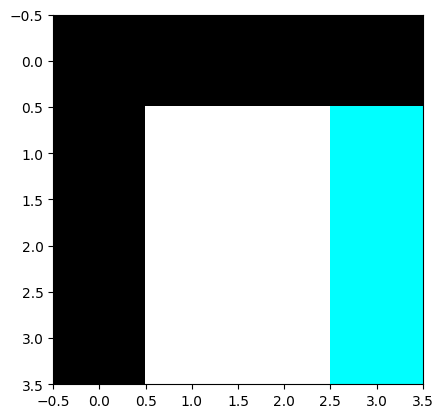

 30%|██▉       | 8349/28000 [12:15<25:41, 12.75it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 4, 3)


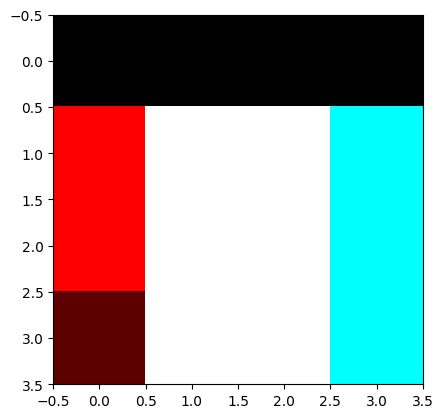

 30%|██▉       | 8399/28000 [12:19<25:32, 12.79it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 4, 3)


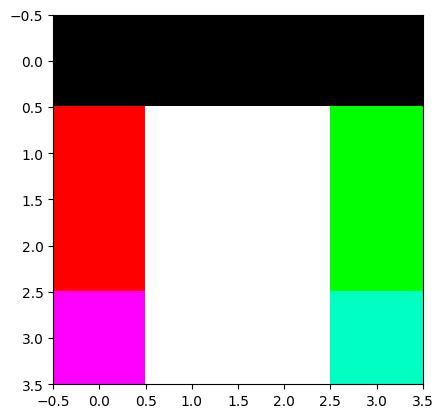

 30%|███       | 8449/28000 [12:23<25:37, 12.72it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 4, 3)


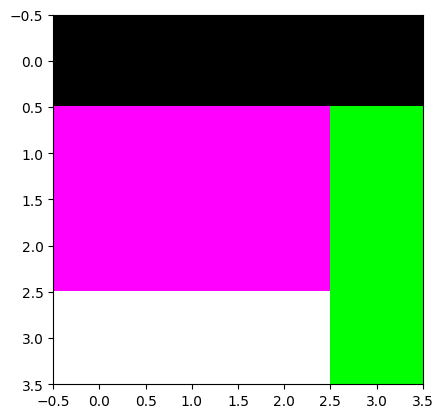

 30%|███       | 8500/28000 [12:28<25:21, 12.82it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 4, 3)


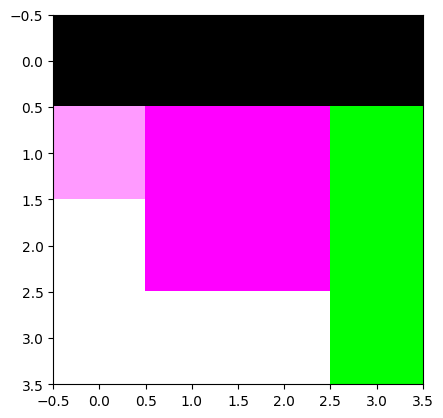

 31%|███       | 8550/28000 [12:32<24:55, 13.01it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 4, 3)


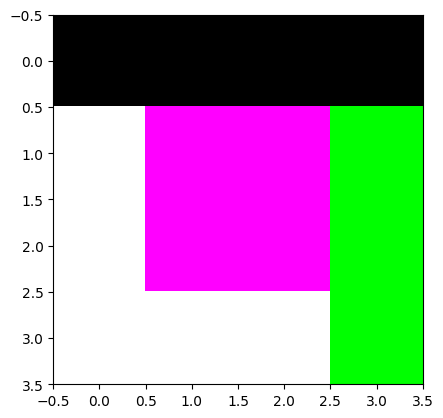

 31%|███       | 8600/28000 [12:37<24:30, 13.19it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 4, 3)


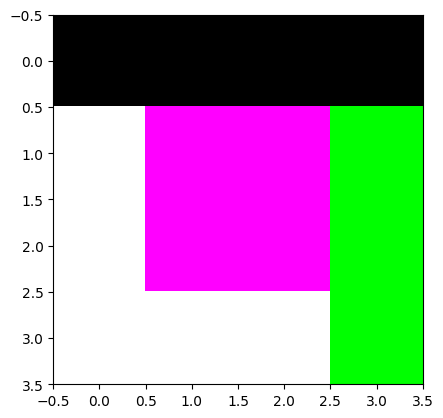

 31%|███       | 8649/28000 [12:42<25:43, 12.54it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 4, 3)


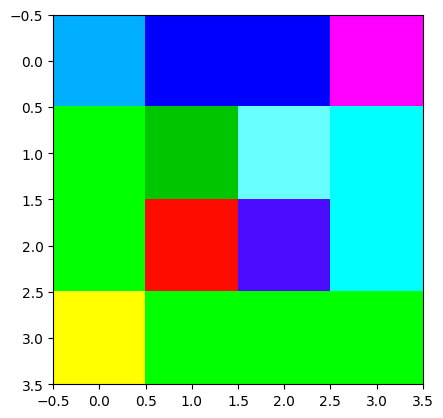

 31%|███       | 8699/28000 [12:46<24:44, 13.00it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 4, 3)


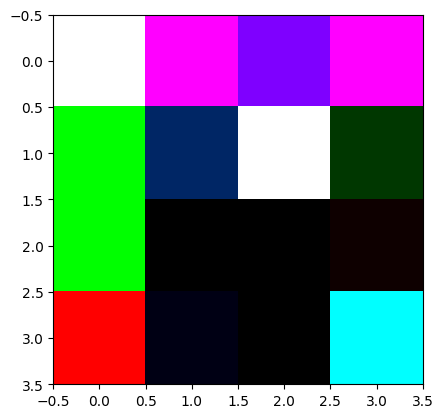

 31%|███       | 8749/28000 [12:50<25:04, 12.80it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 4, 3)


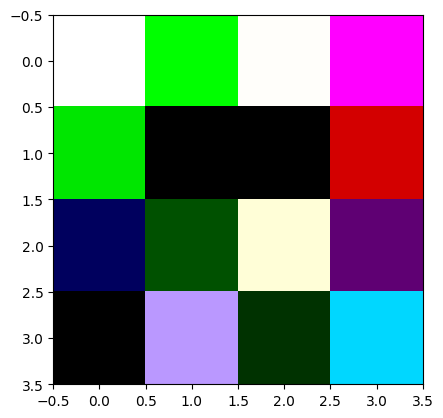

 31%|███▏      | 8800/28000 [12:55<33:16,  9.62it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 4, 3)


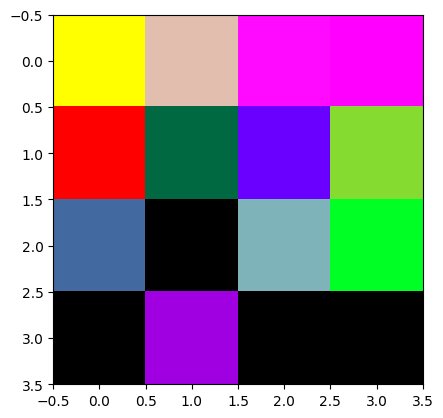

 32%|███▏      | 8849/28000 [13:00<24:59, 12.77it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 4, 3)


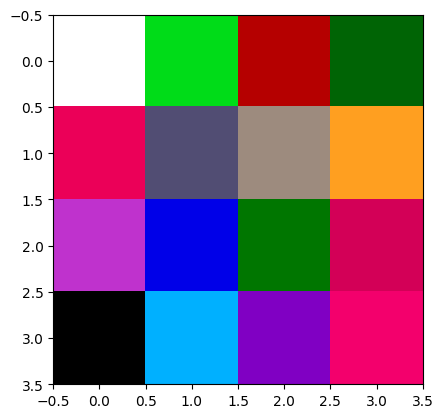

 32%|███▏      | 8899/28000 [13:04<26:46, 11.89it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 4, 3)


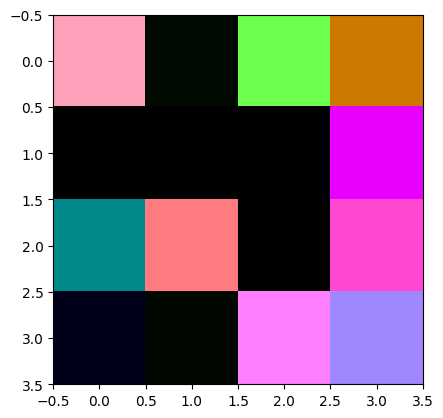

 32%|███▏      | 8949/28000 [13:09<25:07, 12.64it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 4, 3)


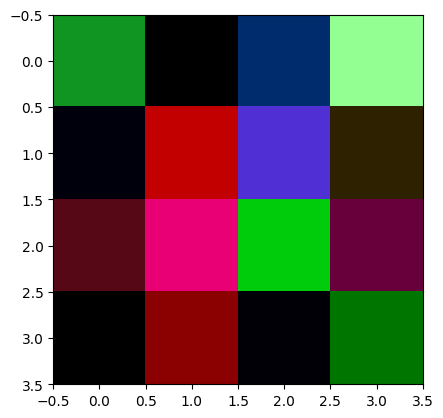

 32%|███▏      | 8999/28000 [13:14<25:12, 12.57it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 4, 3)


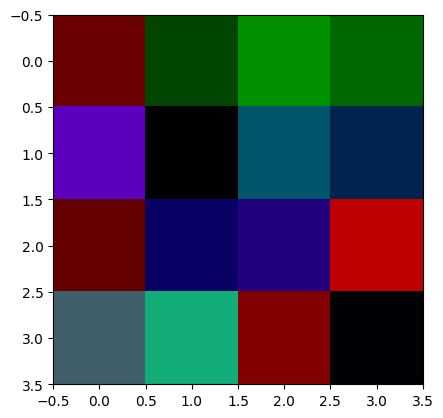

 32%|███▏      | 9049/28000 [13:18<25:22, 12.45it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 4, 3)


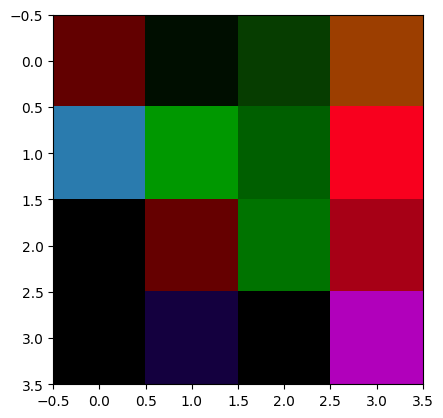

 32%|███▏      | 9099/28000 [13:23<24:12, 13.01it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 4, 3)


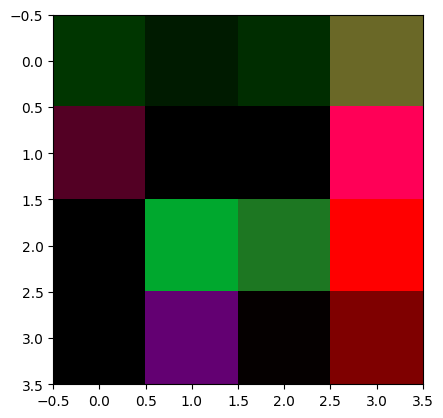

 33%|███▎      | 9149/28000 [13:27<24:09, 13.00it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 4, 3)


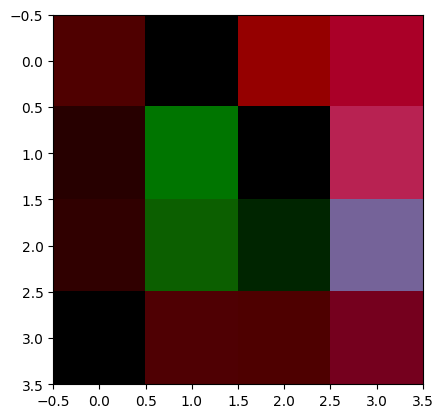

 33%|███▎      | 9199/28000 [13:31<25:25, 12.32it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 4, 3)


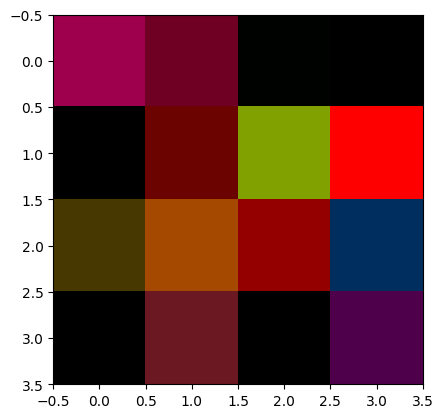

 33%|███▎      | 9249/28000 [13:36<25:42, 12.16it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 4, 3)


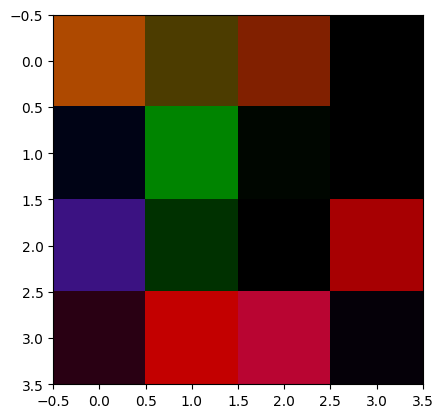

 33%|███▎      | 9299/28000 [13:41<24:36, 12.66it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 4, 3)


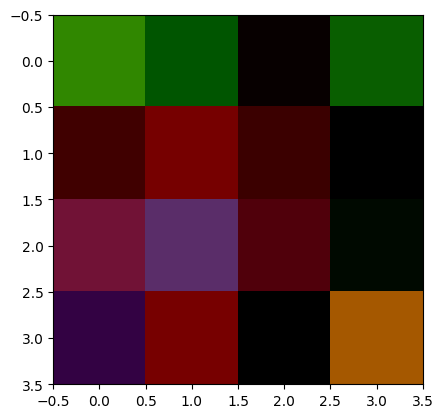

 33%|███▎      | 9349/28000 [13:45<25:19, 12.28it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 4, 3)


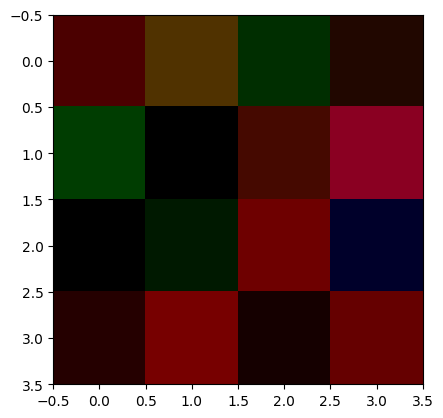

 34%|███▎      | 9399/28000 [13:51<25:02, 12.38it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 4, 3)


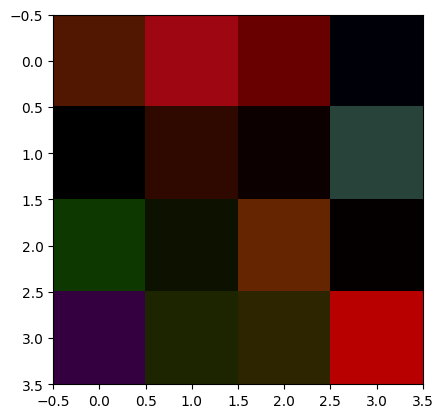

 34%|███▎      | 9449/28000 [13:55<25:12, 12.27it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 4, 3)


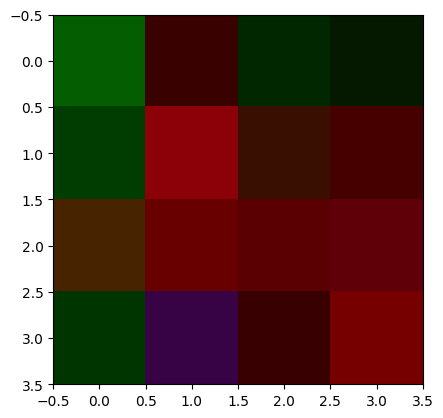

 34%|███▍      | 9499/28000 [13:59<24:17, 12.69it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 4, 3)


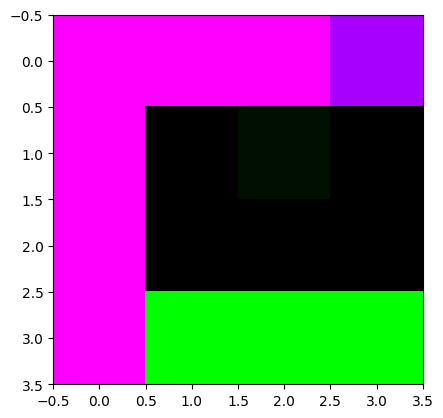

 34%|███▍      | 9549/28000 [14:04<28:01, 10.97it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 4, 3)


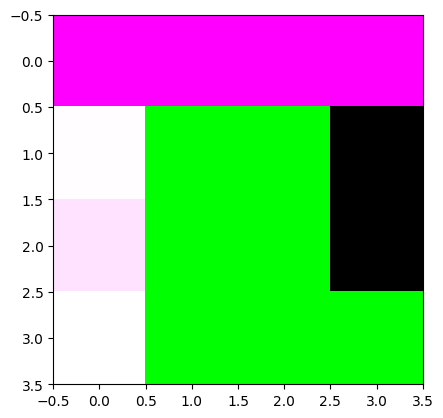

 34%|███▍      | 9599/28000 [14:11<24:32, 12.49it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 4, 3)


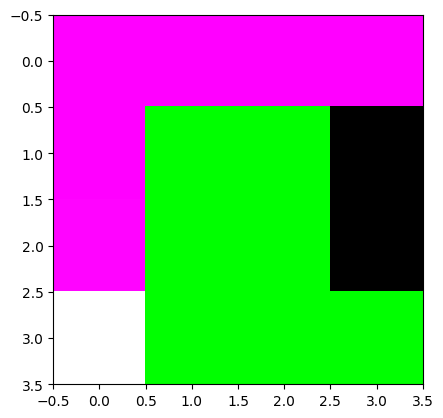

 34%|███▍      | 9650/28000 [14:16<35:20,  8.65it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 4, 3)


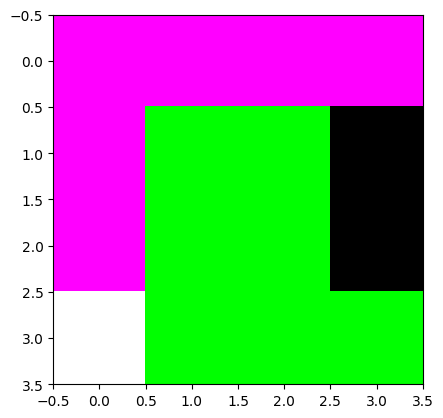

 35%|███▍      | 9700/28000 [14:20<24:50, 12.28it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 4, 3)


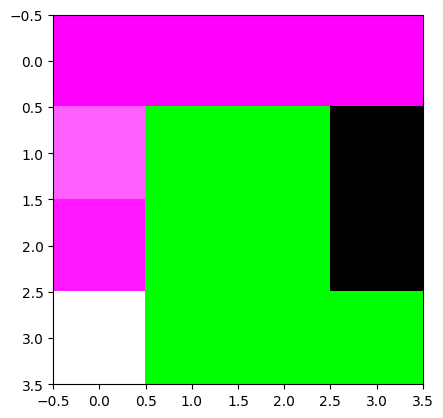

 35%|███▍      | 9750/28000 [14:25<24:48, 12.26it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 4, 3)


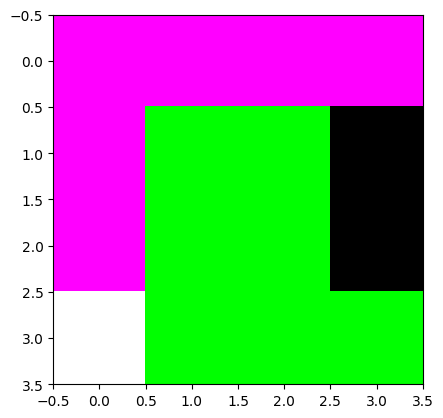

 35%|███▌      | 9800/28000 [14:29<32:17,  9.39it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 4, 3)


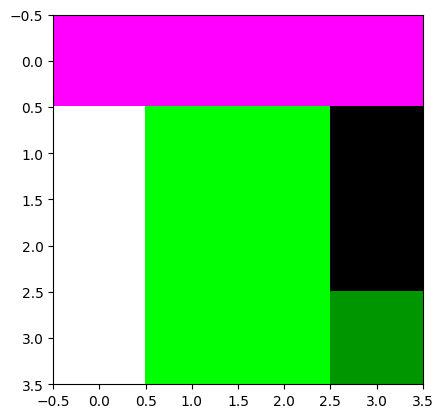

 35%|███▌      | 9849/28000 [14:34<25:50, 11.70it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 4, 3)


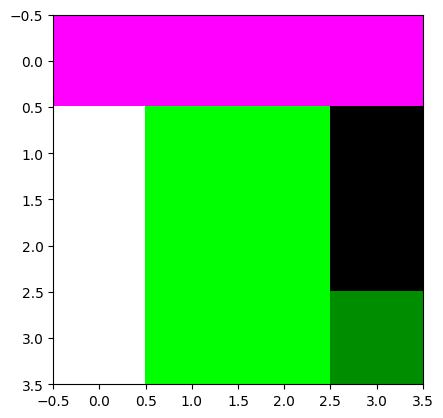

 35%|███▌      | 9899/28000 [14:39<24:46, 12.18it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 4, 3)


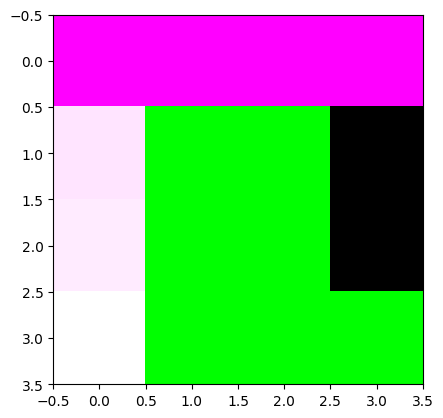

 36%|███▌      | 9950/28000 [14:44<33:01,  9.11it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 4, 3)


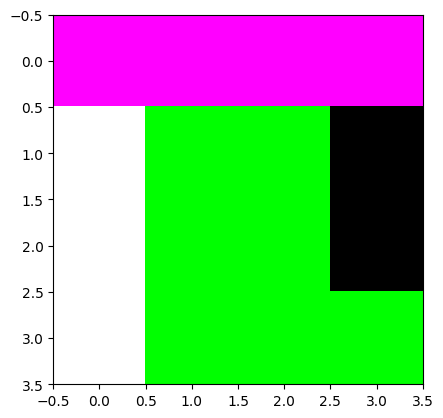

 36%|███▌      | 9999/28000 [14:48<23:48, 12.60it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 4, 3)


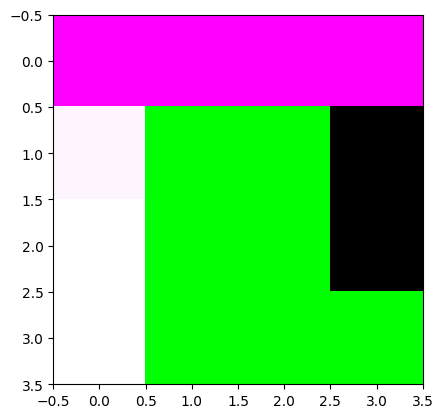

 36%|███▌      | 10049/28000 [14:53<24:06, 12.41it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 4, 3)


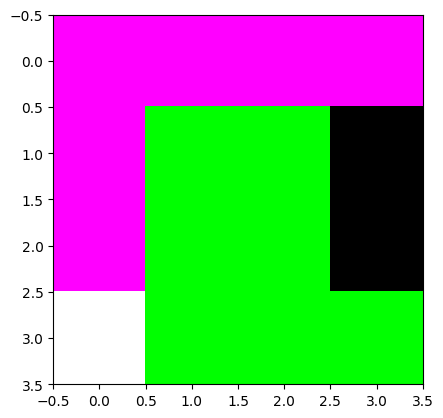

 36%|███▌      | 10100/28000 [14:57<32:20,  9.23it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 4, 3)


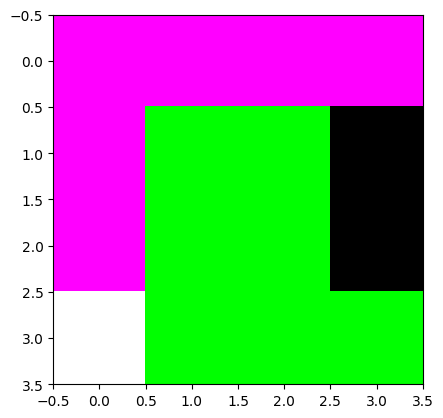

 36%|███▋      | 10150/28000 [15:02<24:14, 12.28it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 4, 3)


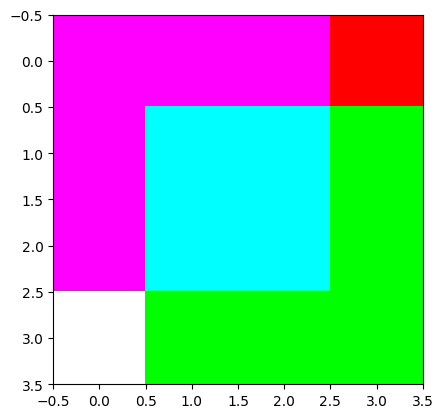

 36%|███▋      | 10200/28000 [15:07<24:45, 11.98it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 4, 3)


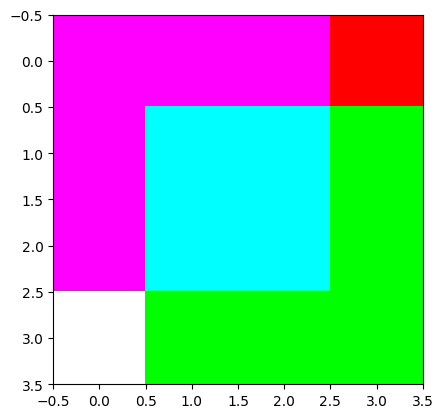

 37%|███▋      | 10250/28000 [15:12<34:12,  8.65it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 4, 3)


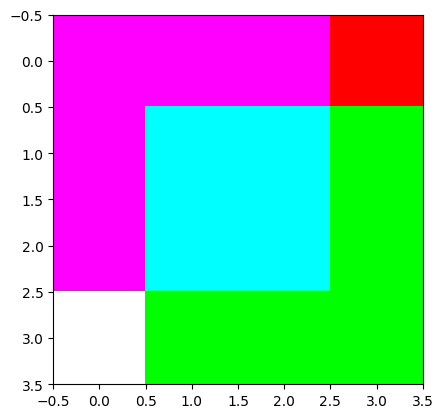

 37%|███▋      | 10300/28000 [15:16<23:45, 12.41it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 4, 3)


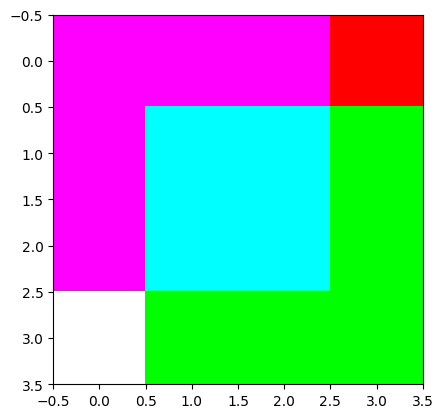

 37%|███▋      | 10350/28000 [15:21<23:46, 12.37it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 4, 3)


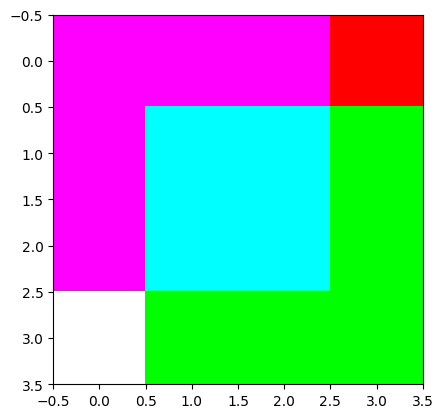

 37%|███▋      | 10400/28000 [15:26<31:01,  9.45it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 4, 3)


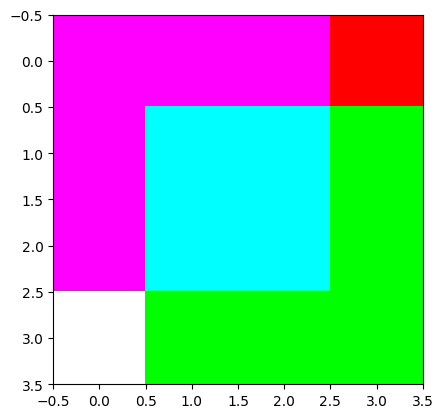

 37%|███▋      | 10449/28000 [15:30<23:01, 12.71it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 4, 3)


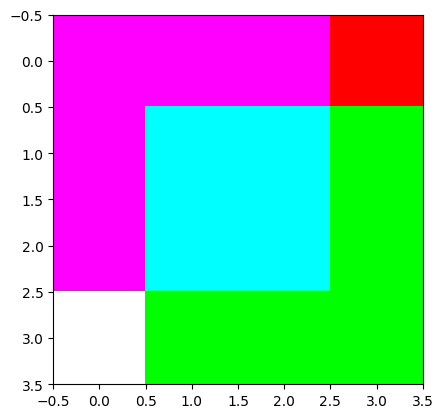

 37%|███▋      | 10499/28000 [15:34<23:17, 12.52it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 4, 3)


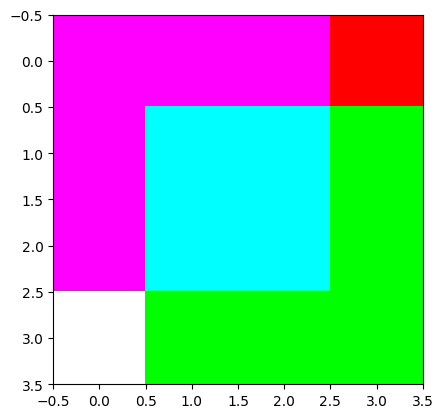

 38%|███▊      | 10549/28000 [15:39<31:40,  9.18it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 4, 3)


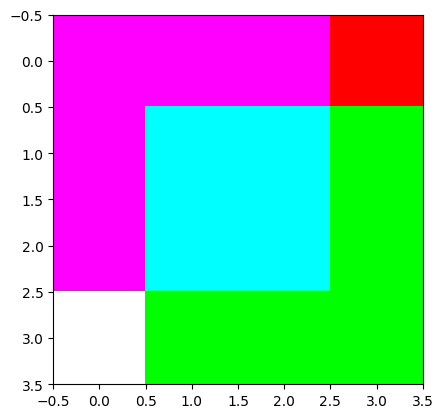

 38%|███▊      | 10599/28000 [15:44<23:14, 12.48it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 4, 3)


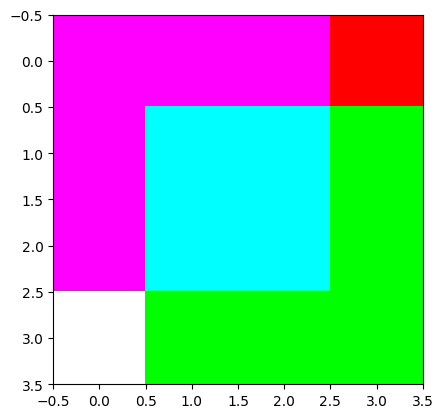

 38%|███▊      | 10649/28000 [15:48<23:06, 12.52it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 4, 3)


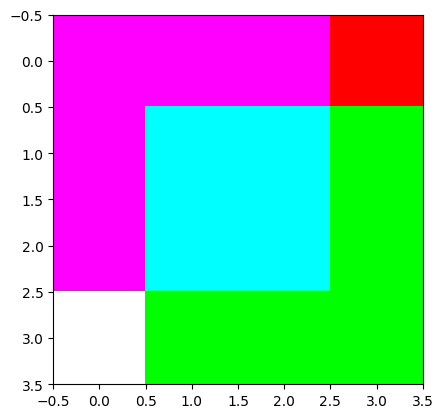

 38%|███▊      | 10700/28000 [15:53<31:09,  9.26it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 4, 3)


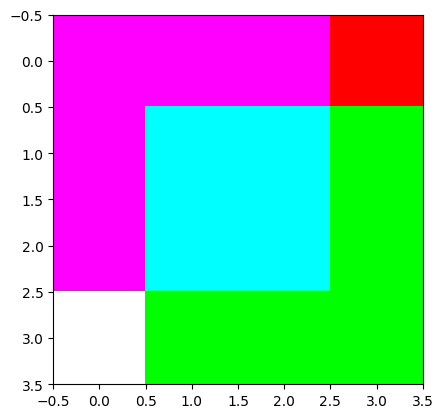

 38%|███▊      | 10750/28000 [15:58<23:40, 12.15it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 4, 3)


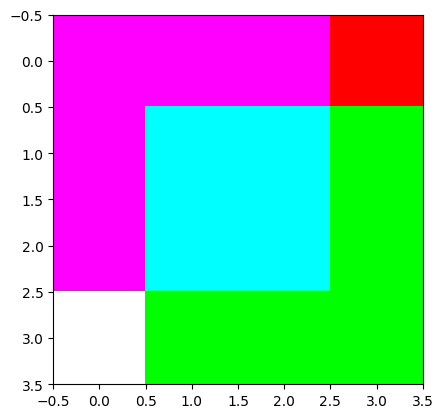

 39%|███▊      | 10800/28000 [16:02<22:36, 12.68it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 4, 3)


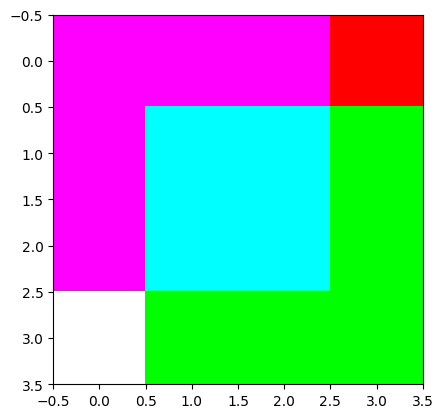

 39%|███▉      | 10850/28000 [16:07<31:53,  8.96it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 4, 3)


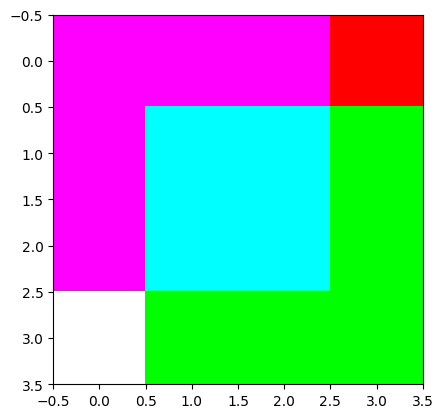

 39%|███▉      | 10899/28000 [16:11<22:18, 12.78it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 4, 3)


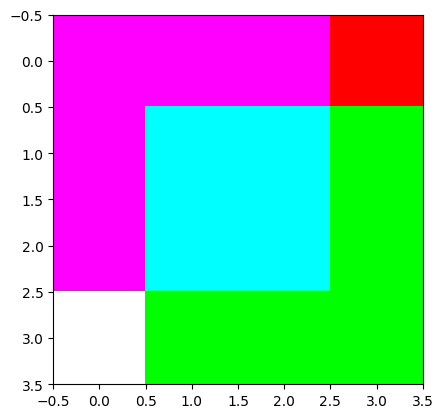

 39%|███▉      | 10949/28000 [16:16<22:05, 12.86it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 4, 3)


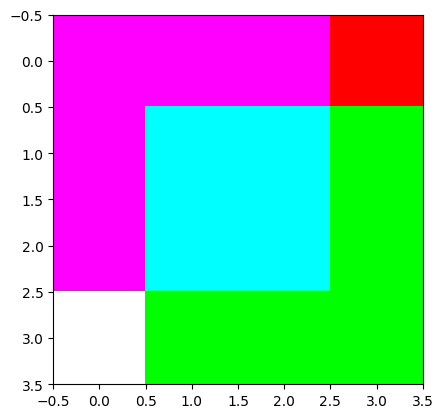

 39%|███▉      | 11000/28000 [16:21<31:22,  9.03it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 4, 3)


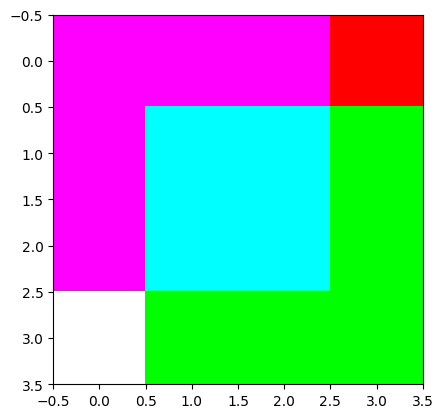

 39%|███▉      | 11049/28000 [16:26<22:53, 12.34it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 4, 3)


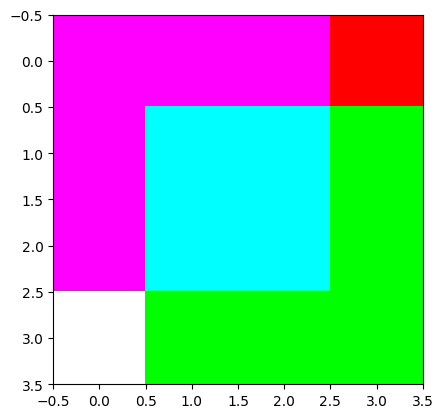

 40%|███▉      | 11099/28000 [16:31<22:39, 12.43it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 4, 3)


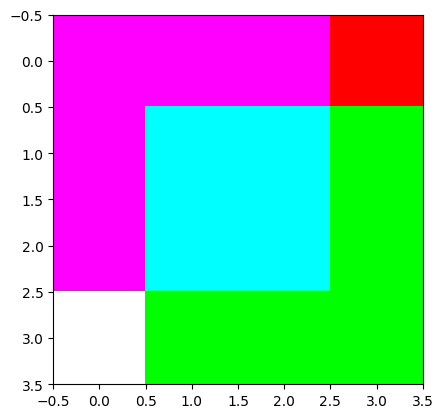

 40%|███▉      | 11150/28000 [16:35<21:58, 12.78it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 4, 3)


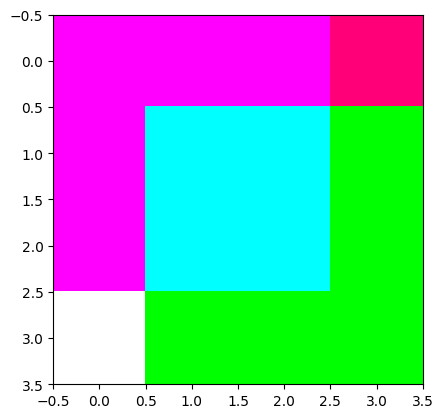

 40%|████      | 11200/28000 [16:40<22:39, 12.35it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 4, 3)


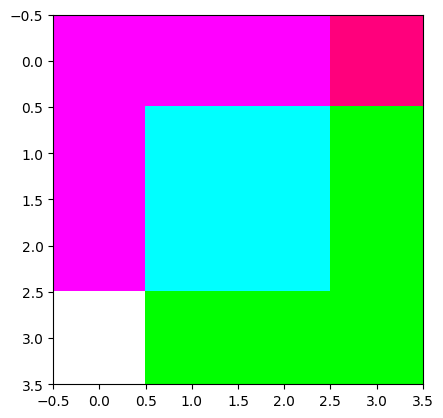

 40%|████      | 11250/28000 [16:45<22:25, 12.45it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 4, 3)


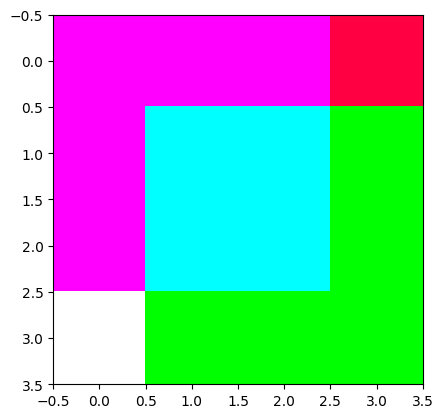

 40%|████      | 11300/28000 [16:49<22:24, 12.42it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 4, 3)


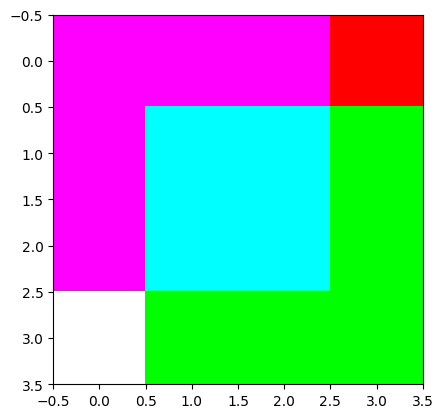

 41%|████      | 11349/28000 [16:54<23:57, 11.58it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 4, 3)


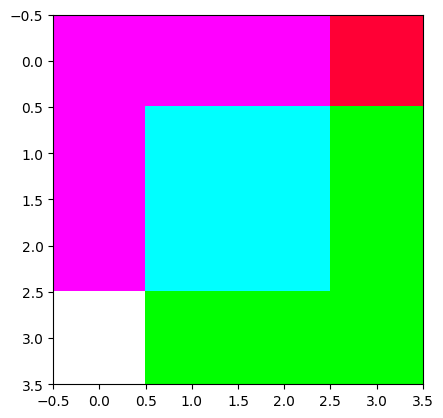

 41%|████      | 11399/28000 [16:58<21:59, 12.58it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 4, 3)


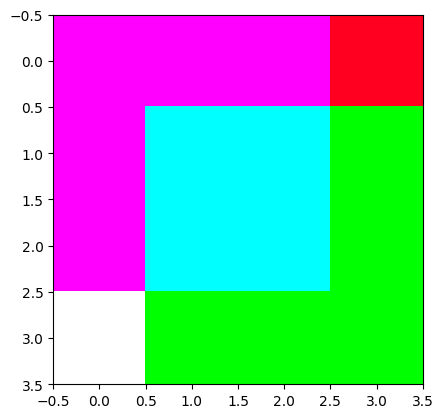

 41%|████      | 11449/28000 [17:03<21:45, 12.68it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 4, 3)


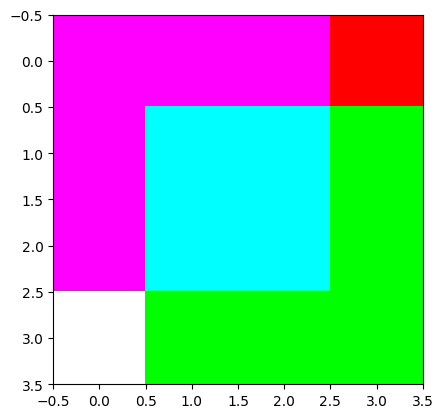

 41%|████      | 11500/28000 [17:08<23:45, 11.57it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 4, 3)


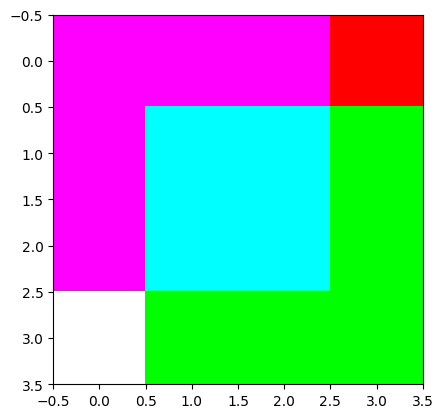

 41%|████▏     | 11550/28000 [17:12<22:18, 12.29it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 4, 3)


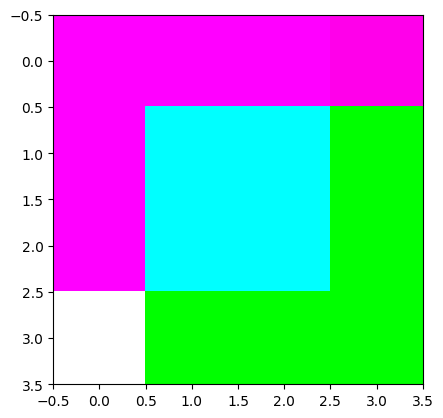

 41%|████▏     | 11600/28000 [17:17<21:58, 12.44it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 4, 3)


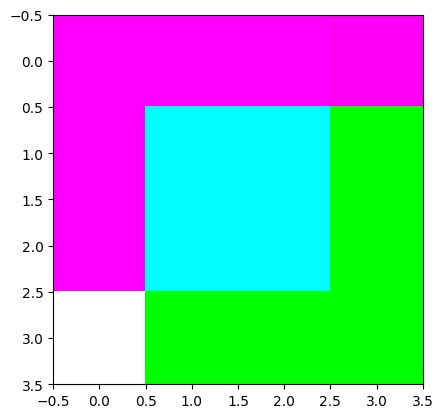

 42%|████▏     | 11650/28000 [17:22<22:06, 12.32it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 4, 3)


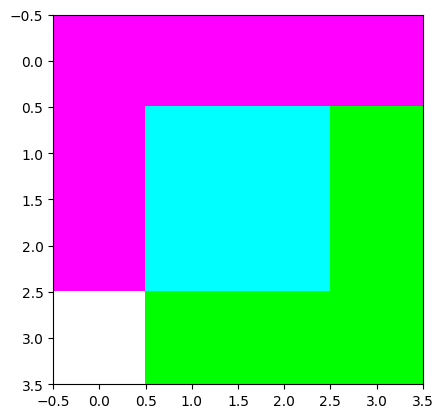

 42%|████▏     | 11700/28000 [17:26<21:20, 12.73it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 4, 3)


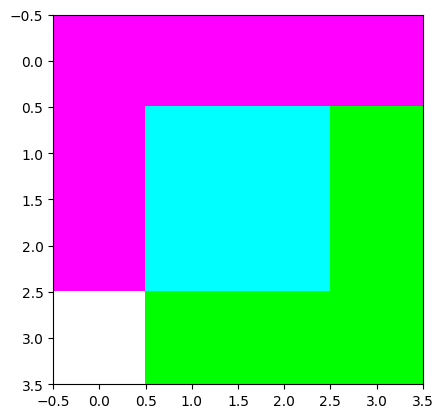

 42%|████▏     | 11750/28000 [17:30<20:58, 12.91it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 4, 3)


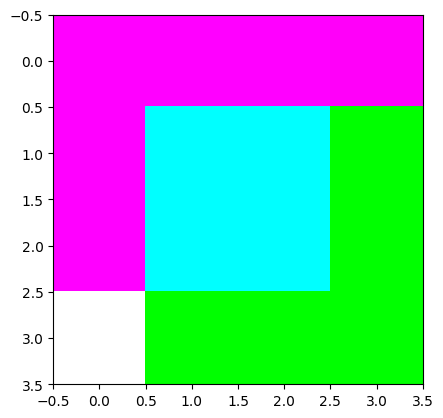

 42%|████▏     | 11799/28000 [17:36<22:59, 11.75it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 4, 3)


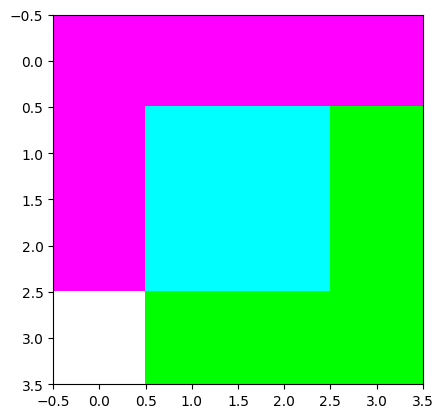

 42%|████▏     | 11849/28000 [17:40<21:14, 12.67it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 4, 3)


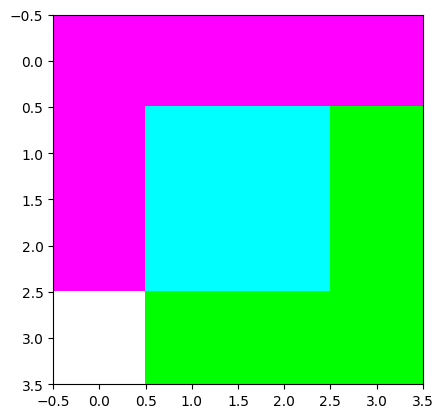

 42%|████▏     | 11899/28000 [17:44<21:30, 12.48it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 4, 3)


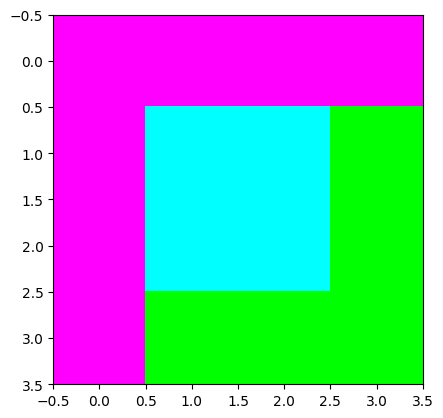

 43%|████▎     | 11950/28000 [17:49<24:28, 10.93it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 4, 3)


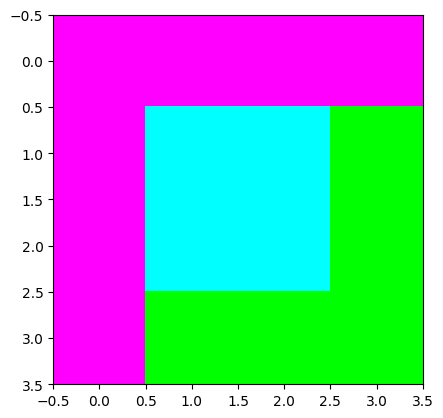

 43%|████▎     | 12000/28000 [17:54<21:18, 12.51it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 4, 3)


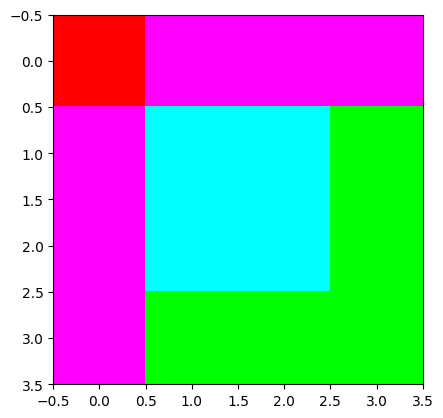

 43%|████▎     | 12050/28000 [17:58<20:53, 12.72it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 4, 3)


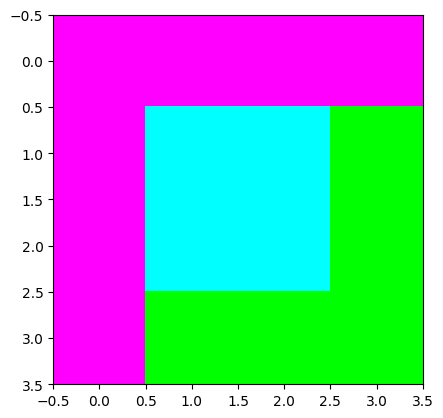

 43%|████▎     | 12099/28000 [18:03<25:49, 10.26it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 4, 3)


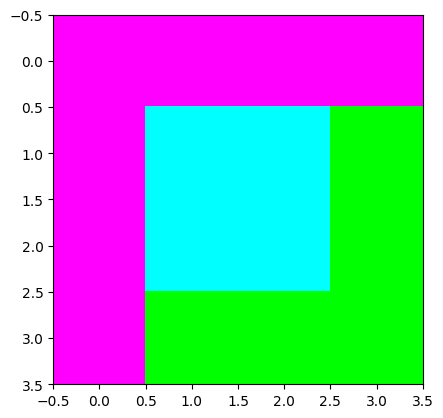

 43%|████▎     | 12149/28000 [18:07<20:47, 12.71it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 4, 3)


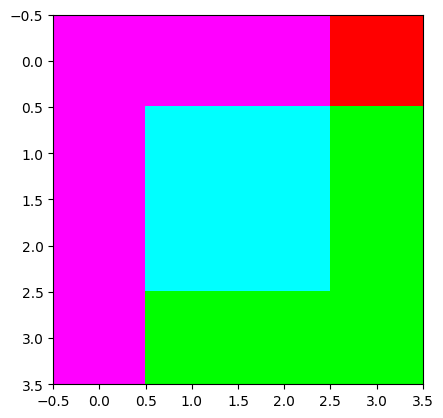

 44%|████▎     | 12199/28000 [18:12<21:09, 12.45it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 4, 3)


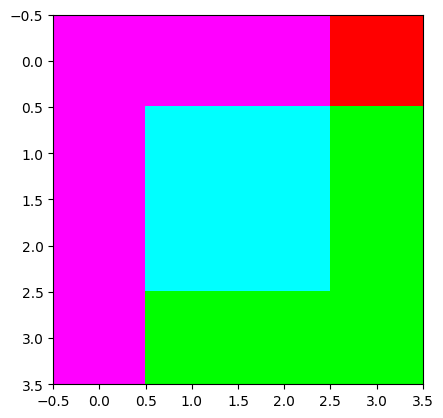

 44%|████▍     | 12250/28000 [18:17<28:52,  9.09it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 4, 3)


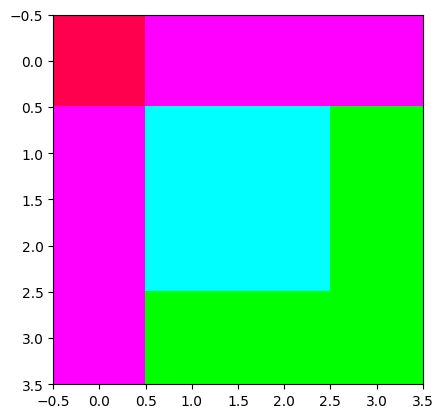

 44%|████▍     | 12299/28000 [18:21<20:59, 12.47it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 4, 3)


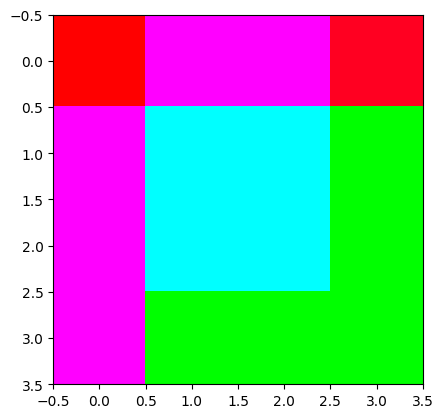

 44%|████▍     | 12349/28000 [18:25<20:30, 12.72it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 4, 3)


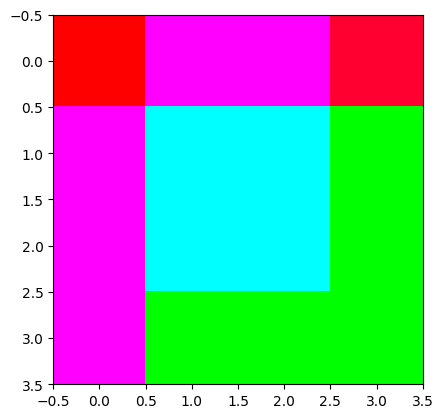

 44%|████▍     | 12400/28000 [18:31<29:25,  8.84it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 4, 3)


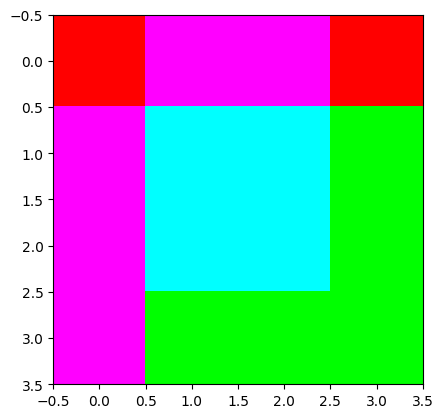

 44%|████▍     | 12449/28000 [18:35<20:59, 12.35it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 4, 3)


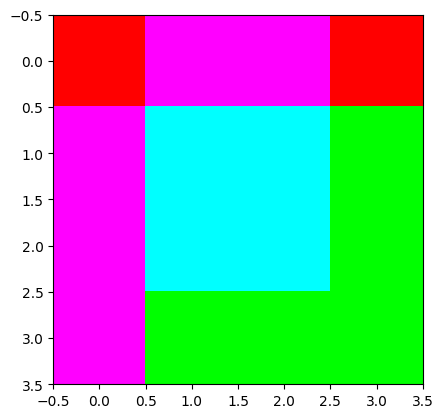

 45%|████▍     | 12499/28000 [18:40<20:22, 12.68it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 4, 3)


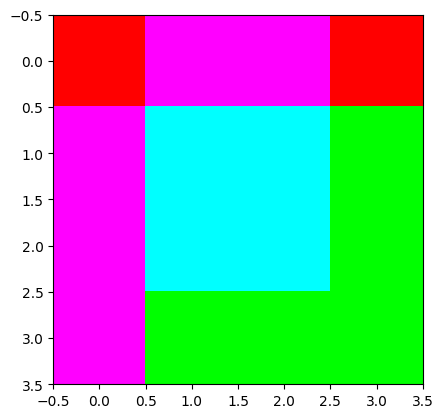

 45%|████▍     | 12550/28000 [18:45<28:24,  9.06it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 4, 3)


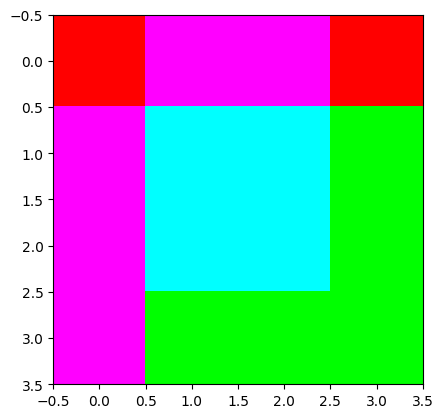

 45%|████▌     | 12600/28000 [18:49<20:36, 12.46it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 4, 3)


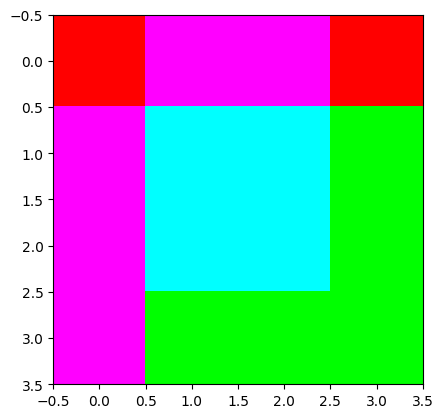

 45%|████▌     | 12650/28000 [18:54<21:45, 11.76it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 4, 3)


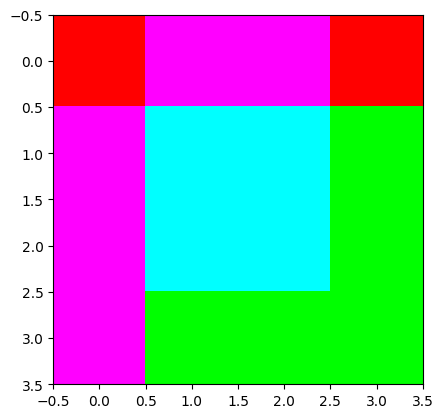

 45%|████▌     | 12700/28000 [18:58<27:19,  9.33it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 4, 3)


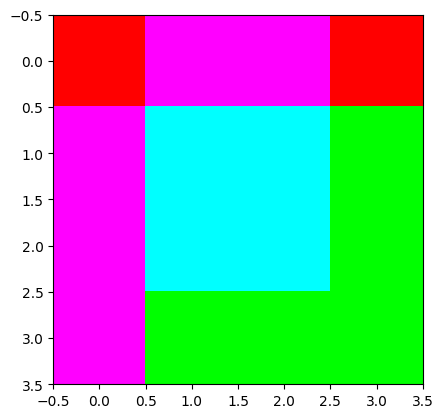

 46%|████▌     | 12749/28000 [19:03<20:44, 12.25it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 4, 3)


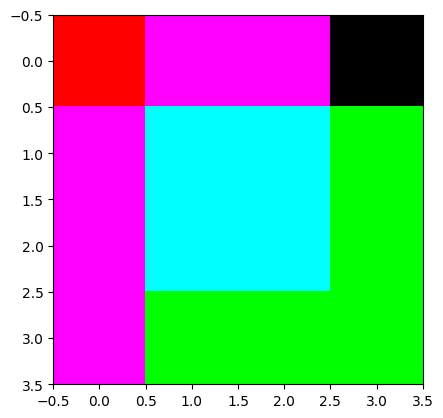

 46%|████▌     | 12799/28000 [19:07<20:14, 12.51it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 4, 3)


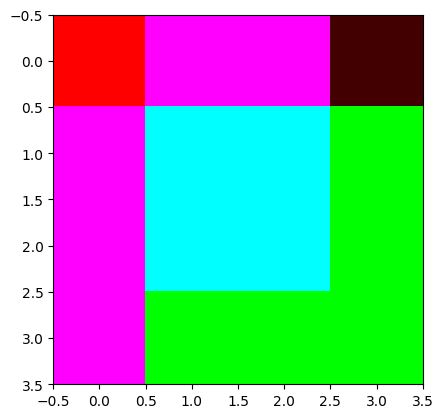

 46%|████▌     | 12850/28000 [19:13<29:49,  8.47it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 4, 3)


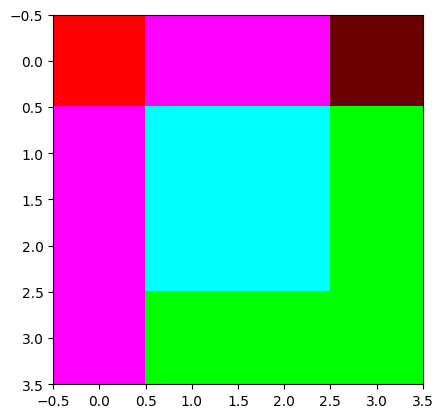

 46%|████▌     | 12899/28000 [19:17<20:28, 12.29it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 4, 3)


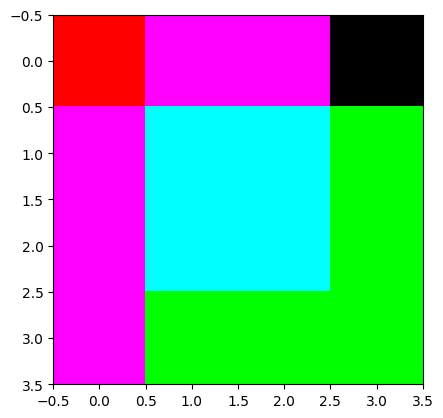

 46%|████▌     | 12949/28000 [19:22<20:27, 12.26it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 4, 3)


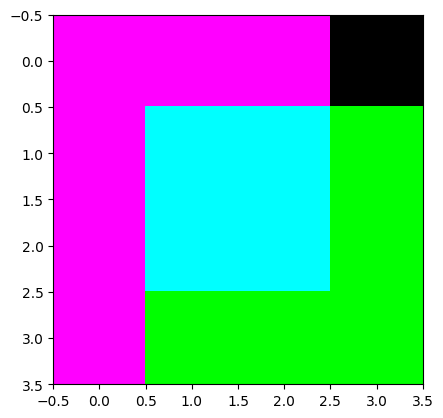

 46%|████▋     | 13000/28000 [19:27<27:06,  9.22it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 4, 3)


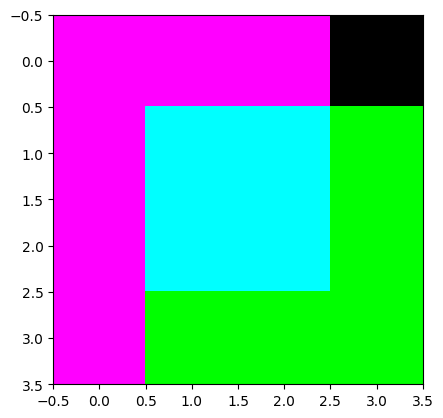

 47%|████▋     | 13050/28000 [19:32<20:00, 12.46it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 4, 3)


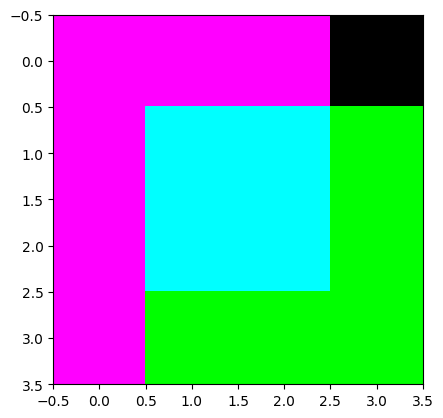

 47%|████▋     | 13100/28000 [19:36<19:38, 12.64it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 4, 3)


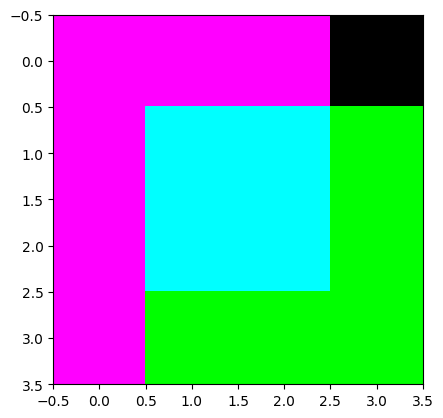

 47%|████▋     | 13150/28000 [19:41<27:39,  8.95it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 4, 3)


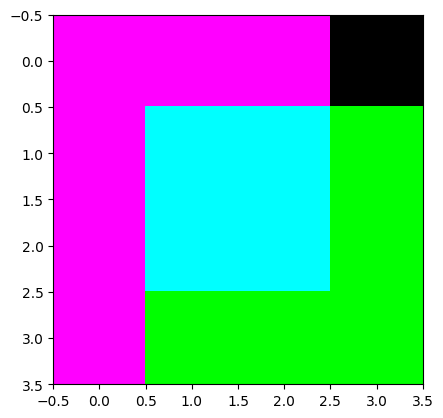

 47%|████▋     | 13199/28000 [19:47<21:55, 11.25it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 4, 3)


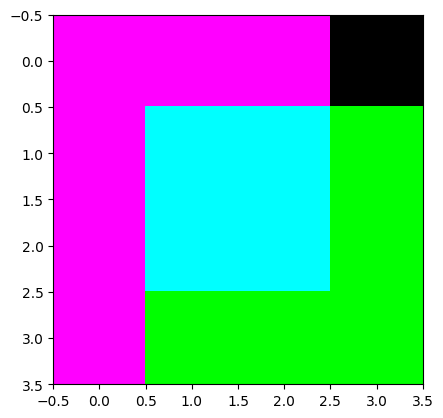

 47%|████▋     | 13249/28000 [19:51<19:41, 12.48it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 4, 3)


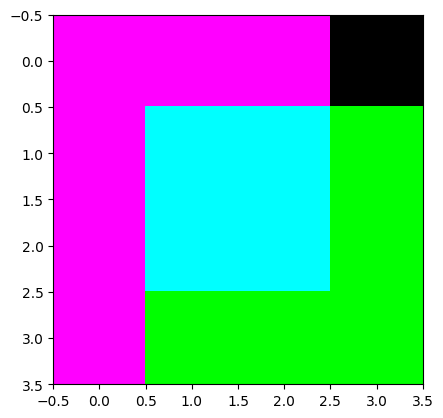

 47%|████▋     | 13299/28000 [19:55<23:35, 10.39it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 4, 3)


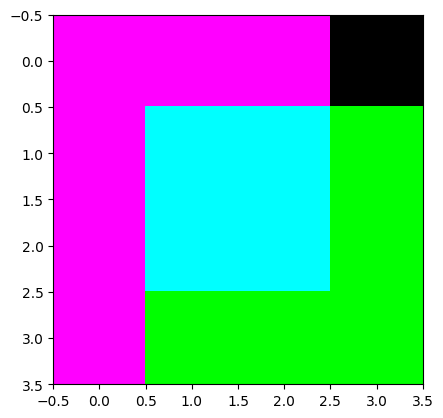

 48%|████▊     | 13349/28000 [20:01<19:40, 12.42it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 4, 3)


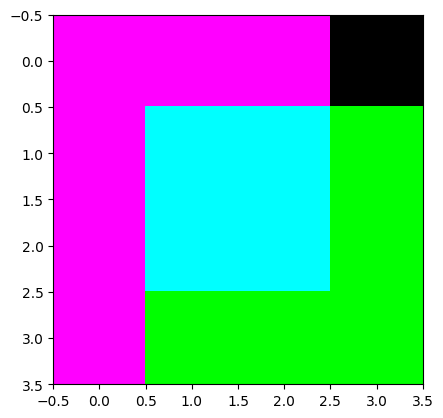

 48%|████▊     | 13365/28000 [20:02<20:18, 12.01it/s]

In [ ]:
gen = Generator().to(DEVICE)
critic = Discriminator().to(DEVICE)
mapper = Z_to_W_MLP().to(DEVICE)

opt_gen = torch.optim.Adam(gen.parameters(), lr=LEARNING_RATE, betas=(0.0,0.99))
opt_critic = torch.optim.Adam(critic.parameters(), lr=LEARNING_RATE, betas=(0.0,0.99))
opt_mapper = torch.optim.Adam(mapper.parameters(), lr=0.001*LEARNING_RATE, betas=(0.0,0.99))

gen.train()
critic.train()
mapper.train()

step = 0
for num_epochs in EPOCHES_PER_BLOCK:
    alpha = 1e-5
    loader, dataset = get_loader(4*2**step)
    print(f"Image Size : {4*2**step}")

    train_an_epoch(critic, gen, mapper, loader, opt_gen, opt_critic, opt_mapper, dataset, alpha, step)

    step += 1
